In [2]:
import pandas as pd
import numpy as np
import os
from pybedtools import BedTool
from pybedtools import BedTool
import pybedtools
import csv


import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True) # Seaborn desaturates matplotlib colors (this is useful if you use both seaborn and basic matplot lib and want colors to be consistent)
import scipy.stats as stats
sns.set(palette='husl', context = 'talk', style='white', font_scale=1)

In [3]:
BASE_PATH = "/".join(os.getcwd().split("/")) # base directory level


#Wynton
# BIN_PATH = os.path.join(BASE_PATH, "bin")  # where my scripts live
# DATA_PATH = os.path.join(BASE_PATH, "data")  # where I dump new data 
# RESULTS_PATH = os.path.join(BASE_PATH, "results")  # where I analyze results

# Local 
RESULTS_PATH = os.path.join(BASE_PATH, "../../../downloads")
DATA_PATH = os.path.join(BASE_PATH, "../../../downloads")  # where I dump new data
COMP_PATH = os.path.join(DATA_PATH,"1KGvsHSMRCA")
FIG_PATH = '/Users/egilbertson/Library/CloudStorage/Box-Box/UCSF/CapraLab/3DGenome/figures/manuscript'



# Non-divergent windows

In [4]:
# windows_to_keep = pd.read_csv('%s/intermediates/windows_to_keep.csv' % DATA_PATH, index_col=0)
# windows_to_keep['windowStopPos'] = windows_to_keep['windowStartPos'] + 2**20

# div_windows = pybedtools.BedTool('%s/phenotype_enrichment_divergent_from_ancestral/data/divergent_windows.bed' % DATA_PATH).to_dataframe()

# merged = windows_to_keep.merge(div_windows, left_on=['chr','windowStartPos'], right_on=['chrom','start'], 
#                    how='left', indicator=True)
# non_div_windows = merged[merged['_merge']=='left_only'].drop(columns=['chrom','start','end','_merge'])

# random_non_div_windows = non_div_windows.sample(n=392, random_state=18)
# random_non_div_windows.to_csv("%s/in_silico_mutagenesis/nondiv_windows/random392_non_divergent_windows.bed" % DATA_PATH, index=False, header=False, sep='\t')

# all = pd.read_csv('%s/in_silico_mutagenesis/nondiv_windows/variants_in_nondivergent_windows.vcf' % DATA_PATH, comment='#', sep='\t', names = ['chr','pos','id','ref','alt','qual','filter','info'])
# info_types = ['AC','AN','DP','AF','EAS_AF','EUR_AF','AFR_AF','AMR_AF','SAS_AF','EX_TARGET','VT','NS']
# splits=all['info'].str.split(';', expand=True)
# splits_11 = splits[splits[11].isnull()]
# splits_12 = splits[~splits[11].isnull()]
# splits_11[11] = splits_11[10]
# splits_11[10] = splits_11[9]
# splits_11[9] = 'NA'
# df = pd.concat([splits_11, splits_12], sort=False).sort_index()

# all[info_types] = df
# all = all.drop(columns=['info'])

# anc = pd.read_csv('%s/tree_sequences/hsmrca_vars_strip.bed' % DATA_PATH, sep='\t', names=['chr','pos','anc','ref','rsid'], skiprows=1)

# a = pd.merge(all, anc, on=['chr','pos'], how='left')
# for col in info_types:
#     print(col)
#     if col!='EX_TARGET':
#         tmp = a[col].str.split('=', expand=True)[1]
#         if col == 'VT':
#             a[col] = tmp
#         else:
#             a[col] = tmp.astype(float)

# a.to_csv('%s/in_silico_mutagenesis/nondiv_windows/ISM_variants_all.txt' % DATA_PATH)

In [4]:

ISM_vars = pd.read_csv('%s/in_silico_mutagenesis/nondiv_windows/ISM_variants_all.txt' % DATA_PATH, index_col=0)

/var/folders/h7/skbyg_hd0lb0s5rwqt8vxx4r0000gn/T/ipykernel_60904/3792645583.py:1: DtypeWarning: Columns (17,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  ISM_vars = pd.read_csv('%s/in_silico_mutagenesis/nondiv_windows/ISM_variants_all.txt' % DATA_PATH, index_col=0)


In [5]:
ISM_vars_snps = ISM_vars[ISM_vars.VT=='SNP']
ISM_vars_snps=ISM_vars_snps.drop(columns=['id','qual','filter','ref_y','DP','AN','NS','EX_TARGET','VT','AC','rsid'])
ISM_vars_snps.columns = ['chr', 'pos', 'ref', 'alt', 'AF', 'EAS_AF', 'EUR_AF', 'AFR_AF',
       'AMR_AF', 'SAS_AF', 'anc']

In [7]:
ISM_vars_snps.shape

(11110961, 11)

In [9]:
def get_non_ancestral_allele(row):
    if row.anc == row.ref:
        non_anc = row.alt
        non_anc_af = float(row.AF)
    elif row.anc == row.alt:
        non_anc = row.ref
        non_anc_af = float(1-row.AF)
    else:
        non_anc="??"
        non_anc_af=np.nan
    return non_anc, non_anc_af

In [10]:
ISM_vars_snps[['non_anc', 'non_anc_af']] = ISM_vars_snps.apply(lambda x: get_non_ancestral_allele(x), axis=1, result_type='expand')

KeyboardInterrupt: 

In [ ]:
ISM_vars_snps

In [ ]:
ISM_vars_snps_with_ancestral = ISM_vars_snps[~ISM_vars_snps.anc.isnull()]

In [ ]:

ISM_vars_snps_with_ancestral_1 = ISM_vars_snps_with_ancestral[ISM_vars_snps_with_ancestral['AF'] >= 0.1]
ISM_vars_snps_with_ancestral_1['pos+1'] = ISM_vars_snps_with_ancestral_1['pos'] + 1
window_bed = pybedtools.BedTool('%s/in_silico_mutagenesis/nondiv_windows/random392_non_divergent_windows_strip.bed' % DATA_PATH)
vars_bed = pybedtools.BedTool.from_dataframe(ISM_vars_snps_with_ancestral_1[['chr','pos','pos+1','anc','non_anc']])

overlap = vars_bed.intersect(window_bed, wao=True).to_dataframe(names=['var_chrm','var_pos','var_pos+1','anc','non_anc','window_chrm','window_start','window_stop','overlap'])
overlap['var_chrm'] = 'chr' + overlap['var_chrm'].astype('str')
overlap = overlap[['var_chrm','var_pos','anc','non_anc','window_start']]

In [ ]:
overlap.sort_values(by = ['var_chrm','var_pos'])

In [ ]:
#overlap.to_csv('%s/in_silico_mutagenesis/nondiv_windows/variants_in_non_divergent_windows_10AF.txt' % DATA_PATH, sep='\t', header=False, index=False)

In [ ]:
# num_vars = 787892
# a = list(range(0,num_vars, 2000))
# b = list(range(2000,num_vars, 2000))
# b.append(num_vars)
# import csv
# with open('%s/in_silico_mutagenesis/nondiv_windows/ISM_splits.txt' % DATA_PATH, 'w+') as f:
#     writer = csv.writer(f, delimiter='\t')
#     for row in zip(a, b):
#         writer.writerow(row)

```run in command line for bash script
```
head -n 1 non_divergent_windows_10AF_variants_1.txt > non_divergent_windows_10AF_variants.txt
for i in {1..394}; do tail -n +2 non_divergent_windows_10AF_variants_$i.txt >> div.tmp; done
sort -k1,1 -k2n,2 div.tmp >> non_divergent_windows_10AF_variants.txt
rm div.tmp
```

In [5]:
ism_nondiv = pd.read_table('%s/in_silico_mutagenesis/nondiv_windows/non_divergent_windows_10AF_variants.txt' % DATA_PATH)
# ancestral 3D dataframes
anc_spear = pd.read_table('%s/comp_tables/anc_window_spearman.csv' % RESULTS_PATH
                    , sep=',', header=[0,1,2,3], index_col=[0,1])
anc_div = 1-anc_spear
window_bed = pybedtools.BedTool("%s/in_silico_mutagenesis/nondiv_windows/random392_non_divergent_windows.bed" % DATA_PATH)

In [6]:
nondiv_windows = window_bed.to_dataframe()[['chrom','start']]
window_tuples = list(nondiv_windows.itertuples(index=False, name=None))

In [7]:
ism_nondiv

,chr,pos,window,ref,alt,mse,1-pearson,1-spearman
0,chr1,13157881,13107200,G,A,3.351077e-09,1.275875e-08,1.186680e-08
1,chr1,13178951,13107200,G,A,1.999163e-08,7.563589e-08,6.913163e-08
2,chr1,13191054,13107200,A,G,1.128466e-09,3.536114e-09,4.245365e-09
3,chr1,13239245,13107200,C,G,1.394443e-08,4.799963e-08,4.990253e-08
4,chr1,13240514,13107200,G,A,4.234076e-10,1.589642e-09,2.596898e-09
...,...,...,...,...,...,...,...,...
787887,chr9,131071387,130023424,C,T,1.136558e-10,1.836913e-10,4.911079e-10
787888,chr9,131071522,130023424,G,A,3.445997e-09,4.535981e-09,6.754828e-09
787889,chr9,131071528,130023424,G,C,4.104026e-09,5.685841e-09,8.443797e-09
787890,chr9,131071793,130023424,A,T,4.872296e-11,6.490886e-11,2.588010e-10


In [8]:
ism_dict = dict.fromkeys(window_tuples)

In [9]:
max_divs = []
all_percs = []
for i in ism_dict.keys():
    max_o = anc_div.loc[i].max()
    chr = i[0]
    window = i[1]
    arry = ism[ism.chr==chr][ism.window==window]
    arry['percent_of_max_observed'] = arry['1-spearman']/max_o
    max_divs.append(arry['1-spearman'].max())
    ism_dict[i] = arry
    all_percs = all_percs + list(arry['percent_of_max_observed'])

NameError: name 'ism' is not defined

Text(0, 0.5, 'Number of windows')

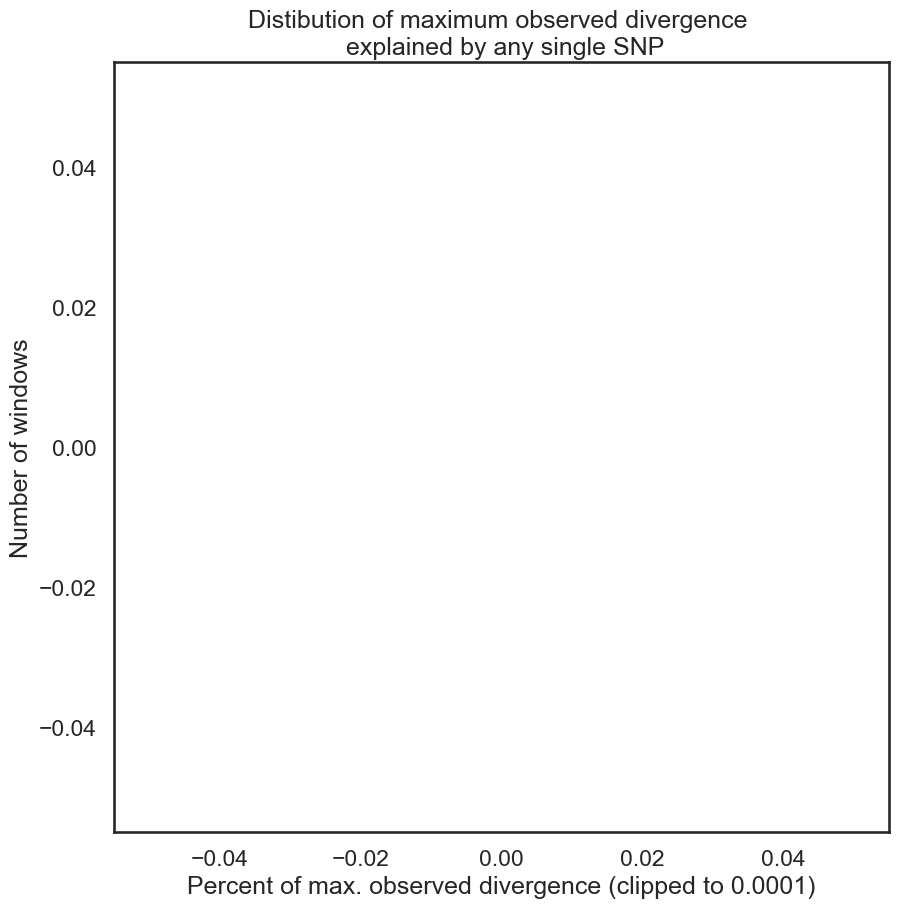

In [10]:
all_percs = np.array(all_percs).clip(0,.00010)

plt.figure(figsize=(10,10))
sns.histplot(all_percs)
plt.title('Distibution of maximum observed divergence \n explained by any single SNP')
plt.xlabel('Percent of max. observed divergence (clipped to 0.0001)')
plt.ylabel('Number of windows')

In [11]:
ism_div = pd.read_table('%s/in_silico_mutagenesis/divergent_windows/divergent_windows_10AF_variants.txt' % DATA_PATH)

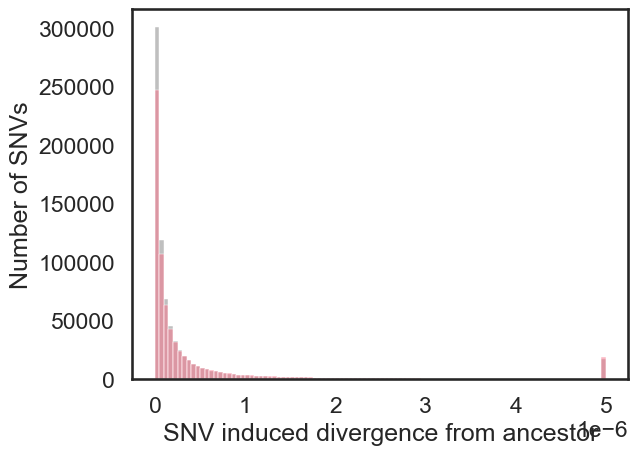

In [12]:
nondiv = np.array(ism_nondiv['1-spearman']).clip(0,.000005)
div = np.array(ism_div['1-spearman']).clip(0,.000005)
sns.histplot(nondiv, color='grey', alpha=0.5, binwidth=0.00000005, common_bins=True)
sns.histplot(div, alpha=0.5, binwidth=0.00000005, common_bins=True)
#plt.yscale('log')
#plt.ylim(0,200000)
plt.ylabel('Number of SNVs')
plt.xlabel('SNV induced divergence from ancestor')
plt.savefig("%s/sup/nondivism.svg" % FIG_PATH , bbox_inches = 'tight')

In [16]:
x.shape[0]

787892

In [15]:
x/x.shape[0]

array([1.50614492e-14, 8.77425263e-14, 5.38825704e-15, ...,
       1.07169467e-14, 3.28472660e-16, 2.43682549e-16])

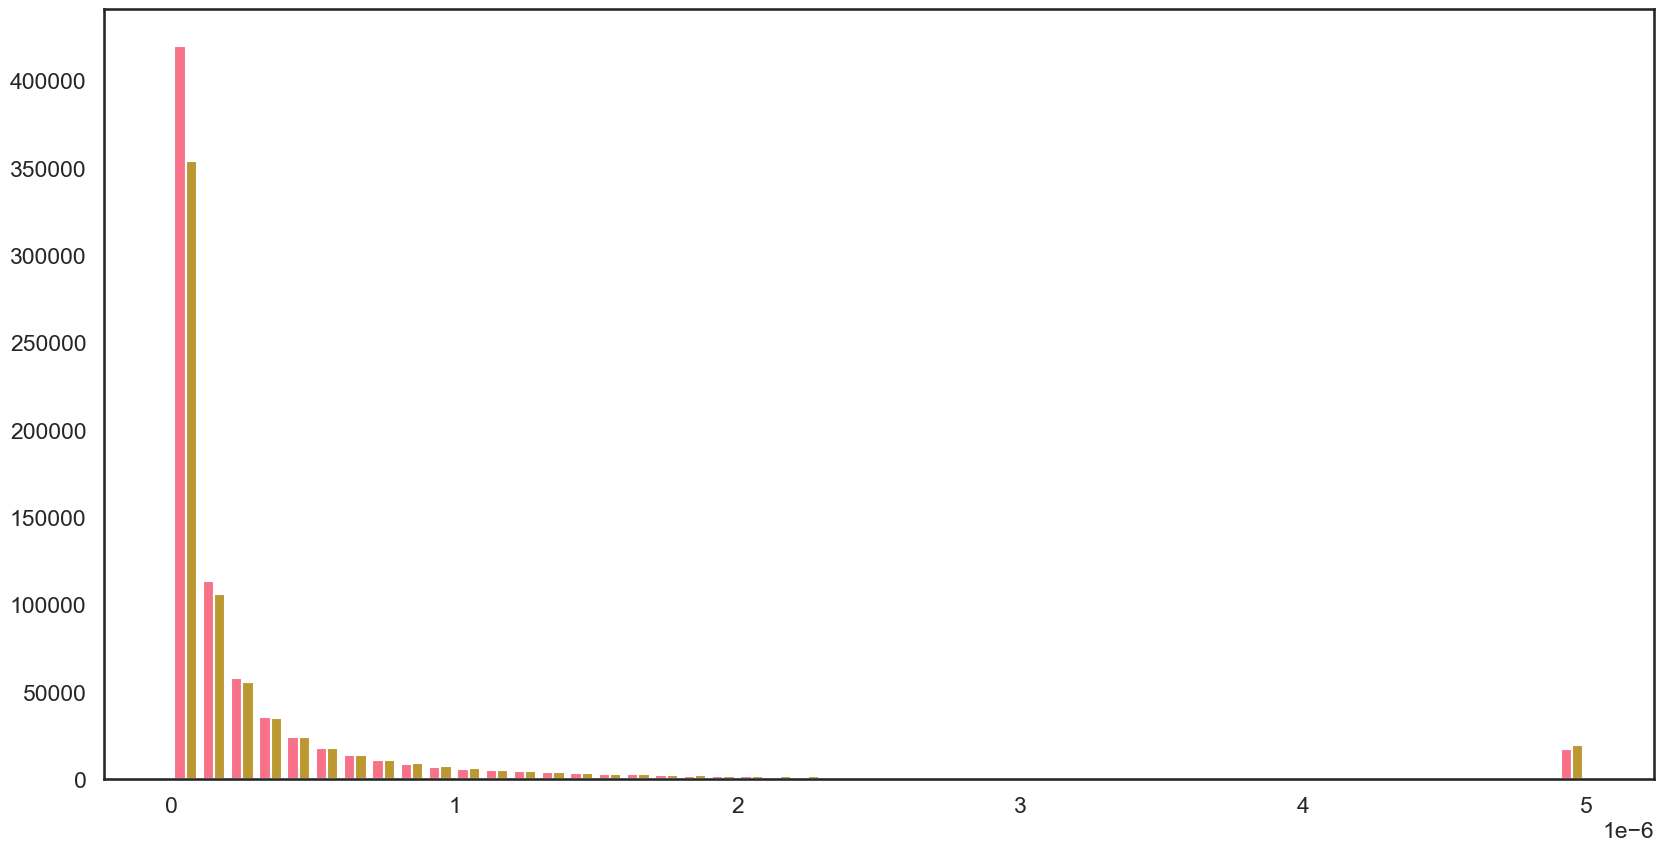

In [23]:
plt.figure(figsize=(20,10))
x = nondiv
y = div
plt.hist([x, y], bins = 50)
plt.savefig("%s/sup/nondivism_sidebyside.svg" % FIG_PATH , bbox_inches = 'tight')

In [25]:
len(x)

787892

(array([0.82640387, 0.07464602, 0.0300295 , 0.01620907, 0.00996583,
        0.00692608, 0.0050083 , 0.00387617, 0.00294076, 0.02397537]),
 array([6.77895517e-11, 5.00061011e-07, 1.00005423e-06, 1.50004745e-06,
        2.00004067e-06, 2.50003389e-06, 3.00002712e-06, 3.50002034e-06,
        4.00001356e-06, 4.50000678e-06, 5.00000000e-06]),
 <BarContainer object of 10 artists>)

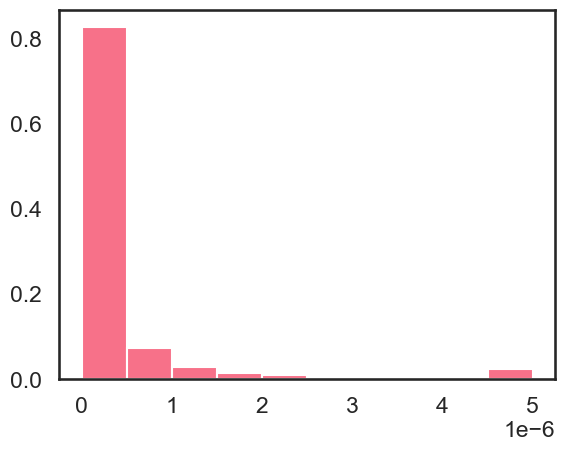

In [32]:
plt.hist(x, weights = np.ones(len(x)) / len(x))

In [97]:
stats.ttest_ind(ism_nondiv['1-spearman'], ism_div['1-spearman'])

TtestResult(statistic=nan, pvalue=nan, df=nan)

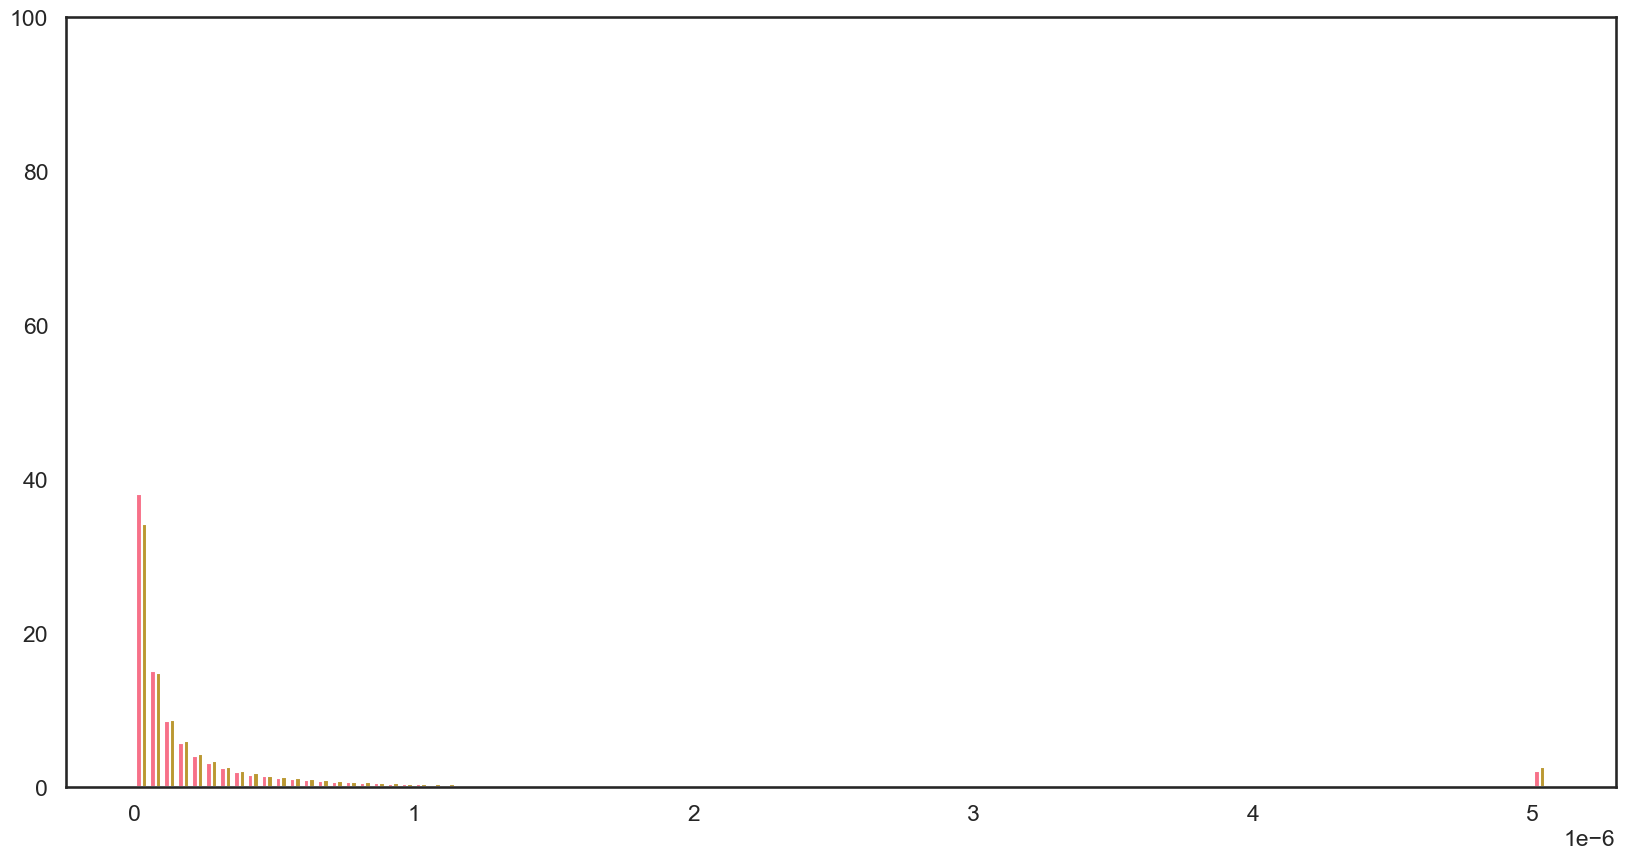

In [98]:
plt.figure(figsize=(20,10))
clipval = 0.000005
nondiv = np.array(ism_nondiv['1-spearman']).clip(0,clipval)
div = np.array(ism_div['1-spearman']).clip(0,clipval)
x = nondiv
y = div
binwidth = 0.00000005
a = plt.hist([x, y], weights = [(np.ones(len(x)) / len(x))*100, (np.ones(len(y)) / len(y))*100], bins = np.arange(0, clipval + binwidth, binwidth))
plt.ylim(0,100)
plt.savefig("%s/sup/nondivism_sidebyside_percent.svg" % FIG_PATH , bbox_inches = 'tight')

In [106]:
high_div = 0.001
print((ism_nondiv[ism_nondiv['1-spearman']>=high_div].shape[0]/ism_nondiv.shape[0]) * 100)
print((ism_div[ism_div['1-spearman']>=high_div].shape[0]/ism_div.shape[0]) * 100)

0.025003426865611023
0.06235087748468247


In [101]:
ism_nondiv.shape

(787892, 8)

(array([709930.,  36431.,  13309.,   7000.,   4274.,   2920.,   1977.,
          1528.,   1182.,   9326.]),
 array([6.77895517e-11, 1.00006101e-06, 2.00005423e-06, 3.00004745e-06,
        4.00004067e-06, 5.00003389e-06, 6.00002712e-06, 7.00002034e-06,
        8.00001356e-06, 9.00000678e-06, 1.00000000e-05]),
 <BarContainer object of 10 artists>)

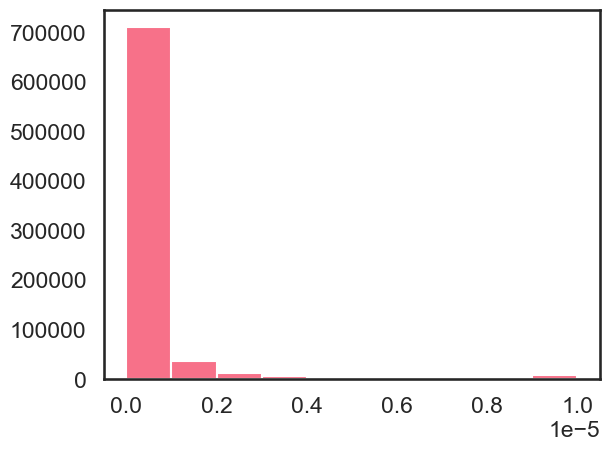

In [51]:
plt.hist(x)

# More divergent than expected

## Set up variants for in silico mutagenesis

```
tabix -R phenotype_enrichment_divergent_from_ancestral/data/divergent_windows.bed /wynton/group/capra/data/wynton_databases/1000_genomes/release/20190312_biallelic_SNV_and_INDEL/ALL.wgs.shapeit2_integrated_snvindels_v2a.GRCh38.27022019.sites.vcf.gz
cd phenotype_enrichment_divergent_from_ancestral/
sed 's/^.\{3\}//' divergent_windows.bed > ../../divergent_windows_strip.bed 
head ../../divergent_windows_strip.bed

  325  head text.txt 
  326  tail text.txt 
  327  mv text.txt variants_in_divergent_windows.vcf
```

In [ ]:
# all = pd.read_csv('%s
 % DATA_PATH, comment='#', sep='\t', names = ['chr','pos','id','ref','alt','qual','filter','info'])


In [ ]:
# all

In [ ]:
# all = all.drop_duplicates()

# info_types = ['AC','AN','DP','AF','EAS_AF','EUR_AF','AFR_AF','AMR_AF','SAS_AF','EX_TARGET','VT','NS']
# splits=all['info'].str.split(';', expand=True)
# splits_11 = splits[splits[11].isnull()]
# splits_12 = splits[~splits[11].isnull()]
# splits_11[11] = splits_11[10]
# splits_11[10] = splits_11[9]
# splits_11[9] = 'NA'
# df = pd.concat([splits_11, splits_12], sort=False).sort_index()

# all[info_types] = df
# all = all.drop(columns=['info'])

In [ ]:
# anc = pd.read_csv('%s/tree_sequences/hsmrca_vars_strip.bed' % DATA_PATH, sep='\t', names=['chr','pos','anc','ref','rsid'], skiprows=1)

In [ ]:
# a = pd.merge(all, anc, on=['chr','pos'], how='left')
# for col in info_types:
#     print(col)
#     if col!='EX_TARGET':
#         tmp = a[col].str.split('=', expand=True)[1]
#         if col == 'VT':
#             a[col] = tmp
#         else:
#             a[col] = tmp.astype(float)

# a.to_csv('ISM_variants_all.txt')

In [ ]:
ISM_vars = pd.read_csv('%s/in_silico_mutagenesis/ISM_variants_all.txt' % DATA_PATH, index_col=0)

In [ ]:
ISM_vars

In [ ]:
ISM_vars.VT.unique()

In [ ]:
ISM_vars_snps = ISM_vars[ISM_vars.VT=='SNP']
ISM_vars_snps=ISM_vars_snps.drop(columns=['id','qual','filter','red','DP','AN','NS','EX_TARGET','VT','AC','rsid'])

In [ ]:
ISM_vars_snps

In [ ]:
def get_non_ancestral_allele(row):
    if row.anc == row.ref:
        non_anc = row.alt
        non_anc_af = float(row.AF)
    elif row.anc == row.alt:
        non_anc = row.ref
        non_anc_af = float(1-row.AF)
    else:
        non_anc="??"
        non_anc_af=np.nan
    return non_anc, non_anc_af

In [ ]:
ISM_vars_snps[['non_anc', 'non_anc_af']] = ISM_vars_snps.apply(lambda x: get_non_ancestral_allele(x), axis=1, result_type='expand')

In [ ]:
ISM_vars_snps

In [ ]:
ISM_vars_snps[ISM_vars_snps.non_anc_af.astype(float) >=.01]

In [ ]:
ISM_vars_snps[ISM_vars_snps.non_anc=="??"]

In [ ]:
ISM_vars_snps_with_ancestral = ISM_vars_snps[~ISM_vars_snps.anc.isnull()]

In [ ]:
ISM_vars_snps_with_ancestral

In [ ]:
ISM_vars_snps_with_ancestral_01 = ISM_vars_snps_with_ancestral[ISM_vars_snps_with_ancestral['AF'] >= 0.01]

In [ ]:
ISM_vars_snps_with_ancestral_01

TODO: Overlap these with the 3D QTLs from Gorkin paper

In [ ]:
ISM_vars_snps_with_ancestral_05 = ISM_vars_snps_with_ancestral[ISM_vars_snps_with_ancestral['AF'] >= 0.05]

In [ ]:
ISM_vars_snps_with_ancestral_05

In [ ]:
ISM_vars_snps_with_ancestral_1 = ISM_vars_snps_with_ancestral[ISM_vars_snps_with_ancestral['AF'] >= 0.1]
ISM_vars_snps_with_ancestral_1['pos+1'] = ISM_vars_snps_with_ancestral_1['pos'] + 1

In [ ]:
ISM_vars_snps_with_ancestral_1

In [ ]:
windows_to_keep = pd.read_csv('%s/intermediates/windows_to_keep.csv' % DATA_PATH, index_col=0)
windows_to_keep['windowStopPos'] = windows_to_keep['windowStartPos'] + 2**20

In [ ]:

ISM_vars_snps_with_ancestral_1 = ISM_vars_snps_with_ancestral[ISM_vars_snps_with_ancestral['AF'] >= 0.1]
ISM_vars_snps_with_ancestral_1['pos+1'] = ISM_vars_snps_with_ancestral_1['pos'] + 1
window_bed = pybedtools.BedTool('%s/divergent_windows_strip.bed' % DATA_PATH)
vars_bed = pybedtools.BedTool.from_dataframe(ISM_vars_snps_with_ancestral_1[['chr','pos','pos+1','anc','non_anc']])


In [ ]:

ISM_vars_snps_with_ancestral_1 = ISM_vars_snps_with_ancestral[ISM_vars_snps_with_ancestral['AF'] >= 0.1]
ISM_vars_snps_with_ancestral_1['pos+1'] = ISM_vars_snps_with_ancestral_1['pos'] + 1
window_bed = pybedtools.BedTool('%s/divergent_windows_strip.bed' % DATA_PATH)
vars_bed = pybedtools.BedTool.from_dataframe(ISM_vars_snps_with_ancestral_1[['chr','pos','pos+1','anc','non_anc']])

overlap = vars_bed.intersect(window_bed, wao=True).to_dataframe(names=['var_chrm','var_pos','var_pos+1','anc','non_anc','window_chrm','window_start','window_stop','overlap'])
overlap['var_chrm'] = 'chr' + overlap['var_chrm'].astype('str')
overlap = overlap[['var_chrm','var_pos','anc','non_anc','window_start']]

In [ ]:
overlap.to_csv('%s/in_silico_mutagenesis/variants_in_divergent_windows_10AF.txt' % DATA_PATH, sep='\t', header=False, index=False)

In [ ]:
overlap.shape[0]

In [ ]:
overlap[overlap.var_pos == 60816904]

In [ ]:
overlap.iloc[179448: 179455]

In [ ]:
ISM_vars_snps_with_ancestral_1[ISM_vars_snps_with_ancestral_1.non_anc=="??"]

In [ ]:
ISM_vars_snps_with_ancestral_1[ISM_vars_snps_with_ancestral_1.pos==60816904]

In [ ]:
a = list(range(0,59796, 2000))
b = list(range(2000,59796, 2000))
b.append(59796)
import csv
with open('%s/in_silico_mutagenesis/ISM_splits_idw_rare_alternate.txt' % DATA_PATH, 'w+') as f:
    writer = csv.writer(f, delimiter='\t')
    for row in zip(a, b):
        writer.writerow(row)

In [ ]:
len(b)

In [ ]:
len(a)

In [ ]:
vars_bed.to_dataframe()

In [ ]:
window_bed.to_dataframe()

## load in mutagenesis files and set up dictionary data structure

run in command line for bash script
```
head -n 1 divergent_windows_10AF_variants_1.txt > divergent_windows_10AF_variants.txt
for i in {1..1444}; do tail -n +2 divergent_windows_10AF_variants_$i.txt >> div.tmp; done
sort -k1,1 -k2n,2 div.tmp >> divergent_windows_10AF_variants.txt
rm div.tmp
```

In [14]:
ism = pd.read_table('%s/in_silico_mutagenesis/divergent_windows/divergent_windows_10AF_variants.txt' % DATA_PATH)
# ancestral 3D dataframes
anc_spear = pd.read_table('%s/comp_tables/anc_window_spearman.csv' % RESULTS_PATH
                    , sep=',', header=[0,1,2,3], index_col=[0,1])
anc_div = 1-anc_spear
window_bed = pybedtools.BedTool('%s/divergent_windows_strip.bed' % DATA_PATH)


In [15]:
ism.sort_values(by=['1-spearman'])

,chr,pos,window,ref,alt,mse,1-pearson,1-spearman
577774,chr5,71827457,71827456,C,T,1.251389e-13,4.507505e-13,1.849754e-11
282898,chr19,14155749,13107200,T,G,2.143719e-12,3.304135e-12,4.166845e-11
220274,chr16,89128971,89128960,A,G,3.215571e-12,5.761169e-12,4.692058e-11
508638,chr4,114294784,114294784,G,C,1.874721e-12,5.825229e-12,5.291789e-11
131731,chr12,107482977,107479040,T,C,2.053415e-12,8.915091e-12,6.268297e-11
...,...,...,...,...,...,...,...,...
7742,chr1,93336657,92798976,T,??,NaN,NaN,NaN
97626,chr11,72947756,72876032,A,??,NaN,NaN,NaN
130679,chr12,104922476,104333312,A,??,NaN,NaN,NaN
472191,chr3,194312746,193986560,T,??,NaN,NaN,NaN


In [16]:
div_windows = window_bed.to_dataframe()[['chrom','start']]
window_tuples = list(div_windows.itertuples(index=False, name=None))
emp = pd.read_table('%s/divergent_windows_exp_distributions.txt' % DATA_PATH, sep=',', index_col=[0,1])

In [17]:
ism_dict = dict.fromkeys(emp.index)

In [18]:
ism_dict.keys()

dict_keys([('chr1', 41418752), ('chr1', 57147392), ('chr1', 70778880), ('chr1', 88604672), ('chr1', 92798976), ('chr1', 96993280), ('chr1', 97517568), ('chr1', 106430464), ('chr1', 110100480), ('chr1', 120061952), ('chr1', 122683392), ('chr1', 123207680), ('chr1', 123731968), ('chr1', 147324928), ('chr1', 152043520), ('chr1', 152567808), ('chr1', 159907840), ('chr1', 160432128), ('chr1', 168820736), ('chr1', 169345024), ('chr1', 172490752), ('chr1', 176685056), ('chr1', 177209344), ('chr1', 187170816), ('chr1', 190316544), ('chr1', 192937984), ('chr1', 193462272), ('chr1', 193986560), ('chr1', 207093760), ('chr1', 246415360), ('chr2', 13107200), ('chr2', 13631488), ('chr2', 14680064), ('chr2', 17825792), ('chr2', 27262976), ('chr2', 27787264), ('chr2', 28835840), ('chr2', 35127296), ('chr2', 35651584), ('chr2', 44040192), ('chr2', 44564480), ('chr2', 48234496), ('chr2', 49807360), ('chr2', 50331648), ('chr2', 53477376), ('chr2', 57147392), ('chr2', 57671680), ('chr2', 70778880), ('chr2

In [19]:
emp.loc[('chr1', 41418752)]

ttest_stat         -26.987165
ttest_pval                0.0
obs_mean             0.011143
exp_mean              0.00319
obs/exp              3.492743
obs-exp              0.007953
-log10(p)          142.835091
direction              higher
sig                      True
numWindowsAbove             2
numWindowsBelow             3
ALL                  0.011143
AFR                  0.010108
EUR                   0.01183
EAS                   0.01318
SAS                  0.011994
AMR                  0.008076
min                  0.000214
max                  0.061708
emp_min               0.00024
emp_max               0.04716
Name: (chr1, 41418752), dtype: object

In [20]:
anc_div.loc[('chr1', 41418752)].max()

0.061707916989559575

In [21]:
anc_div

AFR                                          \
                           ACB                                           
                        female                                           
                       HG01880   HG01883   HG01886   HG01889   HG01894   
chr   windowStartPos                                                     
chr1  1048576         0.000982  0.001551  0.001609  0.001618  0.003944   
      1572864         0.001445  0.001657  0.001909  0.001959  0.004272   
      3145728         0.001283  0.000683  0.002624  0.002458  0.002041   
      3670016         0.005119  0.004878  0.001901  0.002729  0.004874   
      4194304         0.008681  0.007497  0.004502  0.004731  0.011335   
...                        ...       ...       ...       ...       ...   
chr22 46661632        0.007145  0.001892  0.002877  0.008396  0.004389   
      47185920        0.027227  0.006835  0.003085  0.035391  0.003696   
      47710208        0.039303  0.045497  0.065454  0.123312  0.028221   
      48234496        0.183482  0.189969  0.241011  0.325763  0.195117   
      48758784        0.005628  0.014172  0.002837  0.015048  0.012794   

                                                                        ...  \
                                                                        ...   
                                                                        ...   
                       HG01896   HG01915   HG01956   HG01958   HG01985  ...   
chr   windowStartPos                                                    ...   
chr1  1048576         0.002145  0.001217  0.000658  0.002693  0.002143  ...   
      1572864         0.002573  0.001838  0.002096  0.006768  0.002917  ...   
      3145728         0.002661  0.000521  0.002490  0.003151  0.002294  ...   
      3670016         0.001535  0.004503  0.004706  0.004062  0.006236  ...   
      4194304         0.006836  0.007988  0.010622  0.007037  0.014604  ...   
...                        ...       ...       ...       ...       ...  ...   
chr22 46661632        0.002007  0.003275  0.006965  0.002858  0.006226  ...   
      47185920        0.007332  0.002898  0.017533  0.005524  0.002682  ...   
      47710208        0.040250  0.046180  0.030846  0.038820  0.033115  ...   
      48234496        0.174392  0.179873  0.198540  0.168733  0.161755  ...   
      48758784        0.003188  0.005283  0.012890  0.003300  0.013330  ...   

                           SAS                                          \
                           STU                                           
                          male                                           
                       HG03998   HG03999   HG04003   HG04006   HG04033   
chr   windowStartPos                                                     
chr1  1048576         0.000387  0.000713  0.000919  0.000718  0.000841   
      1572864         0.001048  0.000703  0.001067  0.000496  0.001208   
      3145728         0.003141  0.004537  0.000520  0.000528  0.001665   
      3670016         0.005861  0.006603  0.004933  0.004321  0.004428   
      4194304         0.009956  0.011672  0.013004  0.005318  0.008290   
...                        ...       ...       ...       ...       ...   
chr22 46661632        0.003228  0.002667  0.003284  0.002222  0.001290   
      47185920        0.007095  0.003824  0.004329  0.003580  0.003119   
      47710208        0.037299  0.045959  0.036592  0.034629  0.043876   
      48234496        0.166427  0.189953  0.157409  0.160880  0.186454   
      48758784        0.005060  0.005483  0.003194  0.004617  0.005598   

                                                                        
                                                                        
                                                                        
                       HG04039   HG04100   HG04107   HG04210   HG04229  
chr   windowStartPos                                                    
chr1  1048576         0.000

In [22]:
max_divs = []
all_percs = []
for i in ism_dict.keys():
    max_o = anc_div.loc[i].max()
    chr = i[0]
    window = i[1]
    arry = ism[ism.chr==chr][ism.window==window]
    arry['percent_of_max_observed'] = arry['1-spearman']/max_o
    max_divs.append(arry['1-spearman'].max())
    ism_dict[i] = arry
    all_percs = all_percs + list(arry['percent_of_max_observed'])

/var/folders/h7/skbyg_hd0lb0s5rwqt8vxx4r0000gn/T/ipykernel_60904/2230328556.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  arry = ism[ism.chr==chr][ism.window==window]
/var/folders/h7/skbyg_hd0lb0s5rwqt8vxx4r0000gn/T/ipykernel_60904/2230328556.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  arry = ism[ism.chr==chr][ism.window==window]
/var/folders/h7/skbyg_hd0lb0s5rwqt8vxx4r0000gn/T/ipykernel_60904/2230328556.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  arry = ism[ism.chr==chr][ism.window==window]
/var/folders/h7/skbyg_hd0lb0s5rwqt8vxx4r0000gn/T/ipykernel_60904/2230328556.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  arry = ism[ism.chr==chr][ism.window==window]
/var/folders/h7/skbyg_hd0lb0s5rwqt8vxx4r0000gn/T/ipykernel_60904/2230328556.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  arry = ism[ism.chr==

In [23]:
arry

,chr,pos,window,ref,alt,mse,1-pearson,1-spearman,percent_of_max_observed
427796,chr22,48237421,48234496,A,T,4.438659e-10,7.412495e-09,6.707550e-09,1.936371e-08
427798,chr22,48237817,48234496,T,C,4.000753e-10,6.627718e-09,5.150825e-09,1.486968e-08
427800,chr22,48238411,48234496,T,C,8.939167e-10,1.435870e-08,1.246882e-08,3.599565e-08
427802,chr22,48239149,48234496,G,C,5.705385e-09,9.134697e-08,4.275704e-08,1.234333e-07
427804,chr22,48239474,48234496,A,G,2.117566e-08,3.224275e-07,2.104907e-07,6.076556e-07
...,...,...,...,...,...,...,...,...,...
433808,chr22,49281890,48234496,G,A,4.770842e-10,8.065142e-09,1.722946e-08,4.973891e-08
433809,chr22,49282160,48234496,C,T,3.236197e-11,5.029821e-10,1.729698e-09,4.993385e-09
433810,chr22,49282787,48234496,C,T,1.657518e-09,2.681234e-08,6.368712e-08,1.838554e-07
433811,chr22,49282856,48234496,A,T,2.621071e-11,4.014075e-10,1.398813e-09,4.038167e-09


In [24]:
all_percs

[3.6100572687315266e-08,
 7.123785990269975e-08,
 4.394926163037874e-08,
 2.170255941931522e-08,
 2.551008005354474e-08,
 7.005537039788266e-08,
 9.433477409357883e-09,
 3.479463214610916e-08,
 3.509237662936457e-08,
 3.037763049234916e-08,
 5.2859693176586566e-08,
 8.316816043090283e-08,
 5.240541113835767e-09,
 4.422432952417036e-08,
 3.909275622352592e-09,
 6.809140754995686e-08,
 3.504574784730071e-09,
 5.400067070515027e-09,
 3.975269463368731e-08,
 1.6756472128458032e-08,
 1.542250610057489e-08,
 1.0883109156434879e-07,
 3.219971910423107e-07,
 1.498352896107587e-07,
 5.527385937118985e-08,
 3.912667395318091e-08,
 1.654396024426812e-07,
 3.7641143243481825e-07,
 1.2723563161019955e-06,
 1.5620835580811685e-07,
 0.00035939151014894775,
 3.578651505709642e-07,
 3.567983505342287e-07,
 1.5305448912459165e-07,
 1.8840338900491709e-06,
 2.6225881425032355e-07,
 1.0626550318125592e-06,
 3.8379495083446126e-07,
 1.3980391596127033e-07,
 3.4913097895149297e-06,
 4.7319044385250667e-07,


In [25]:
ism_dict[('chr1',
  41418752)]['percent_of_max_observed']

0       3.610057e-08
1       7.123786e-08
2       4.394926e-08
3       2.170256e-08
4       2.551008e-08
            ...     
1741    2.085315e-08
1742    1.163570e-08
1743    1.569188e-08
1744    6.708690e-08
1745    1.684230e-09
Name: percent_of_max_observed, Length: 1746, dtype: float64

In [26]:
import statistics
statistics.median(all_percs)

1.5454790824413317e-06

Text(0, 0.5, 'Number of windows')

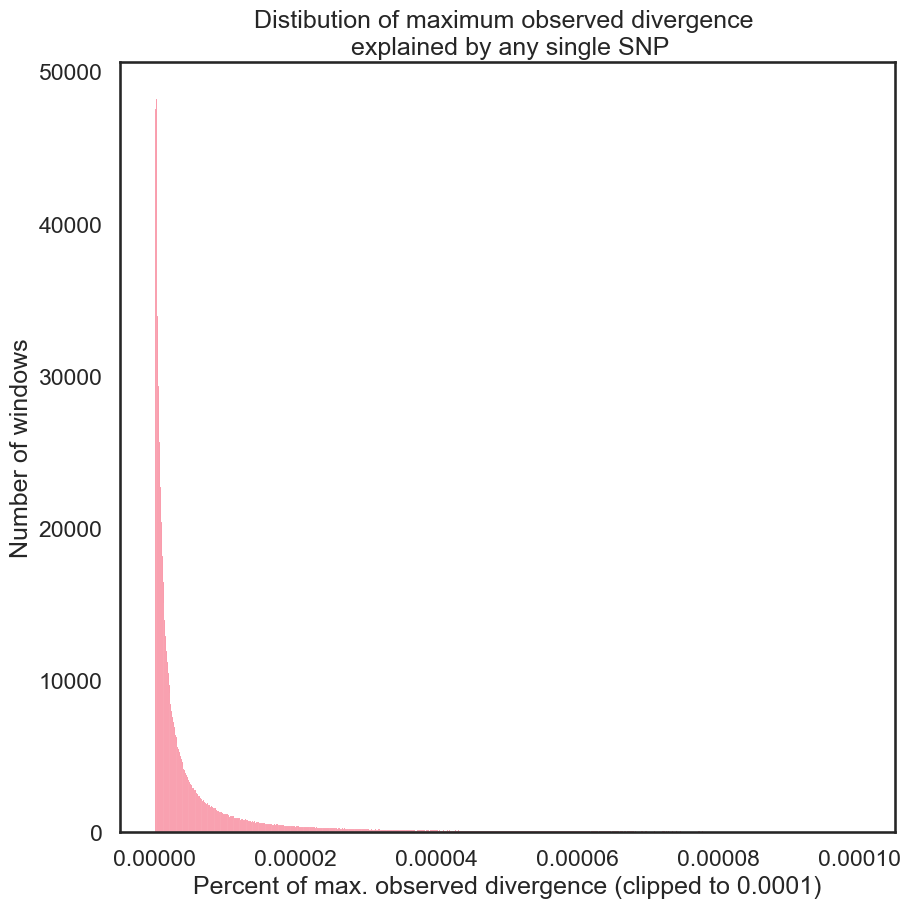

In [27]:
all_percs = np.array(all_percs).clip(0,.00010)

plt.figure(figsize=(10,10))
sns.histplot(all_percs)
plt.title('Distibution of maximum observed divergence \n explained by any single SNP')
plt.xlabel('Percent of max. observed divergence (clipped to 0.0001)')
plt.ylabel('Number of windows')

In [28]:
ism_dict.keys()

dict_keys([('chr1', 41418752), ('chr1', 57147392), ('chr1', 70778880), ('chr1', 88604672), ('chr1', 92798976), ('chr1', 96993280), ('chr1', 97517568), ('chr1', 106430464), ('chr1', 110100480), ('chr1', 120061952), ('chr1', 122683392), ('chr1', 123207680), ('chr1', 123731968), ('chr1', 147324928), ('chr1', 152043520), ('chr1', 152567808), ('chr1', 159907840), ('chr1', 160432128), ('chr1', 168820736), ('chr1', 169345024), ('chr1', 172490752), ('chr1', 176685056), ('chr1', 177209344), ('chr1', 187170816), ('chr1', 190316544), ('chr1', 192937984), ('chr1', 193462272), ('chr1', 193986560), ('chr1', 207093760), ('chr1', 246415360), ('chr2', 13107200), ('chr2', 13631488), ('chr2', 14680064), ('chr2', 17825792), ('chr2', 27262976), ('chr2', 27787264), ('chr2', 28835840), ('chr2', 35127296), ('chr2', 35651584), ('chr2', 44040192), ('chr2', 44564480), ('chr2', 48234496), ('chr2', 49807360), ('chr2', 50331648), ('chr2', 53477376), ('chr2', 57147392), ('chr2', 57671680), ('chr2', 70778880), ('chr2

In [29]:
emp

ttest_stat     ttest_pval  obs_mean  exp_mean   obs/exp  \
chr   windowStartPos                                                            
chr1  41418752        -26.987165  1.461871e-143  0.011143  0.003190  3.492743   
      57147392        -11.867927   9.060743e-32  0.021517  0.007885  2.728665   
      70778880         -5.334215   1.032114e-07  0.003761  0.002849  1.319976   
      88604672        -17.578602   7.272380e-66  0.014955  0.002522  5.929643   
      92798976        -16.384539   8.147811e-58  0.071182  0.008426  8.447434   
...                          ...            ...       ...       ...       ...   
chr21 35127296         -8.395653   7.093248e-17  0.030532  0.022997  1.327648   
chr22 22020096        -10.467888   3.332675e-25  0.023887  0.017606  1.356793   
      22544384         -9.387509   1.188089e-20  0.011776  0.007743  1.520958   
      47710208        -26.485256  7.297025e-139  0.055388  0.020211  2.740559   
      48234496        -55.442420   0.000000e+00  0.204145  0.035823  5.698711   

                       obs-exp   -log10(p) direction   sig  numWindowsAbove  \
chr   windowStartPos                                                          
chr1  41418752        0.007953  142.835091    higher  True                2   
      57147392        0.013631   31.042836    higher  True                1   
      70778880        0.000912    6.986272    higher  True                0   
      88604672        0.012433   65.138323    higher  True                7   
      92798976        0.062755   57.088959    higher  True                0   
...                        ...         ...       ...   ...              ...   
chr21 35127296        0.007535   16.149155    higher  True                0   
chr22 22020096        0.006282   24.477207    higher  True                0   
      22544384        0.004034   19.925151    higher  True                0   
      47710208        0.035178  138.136854    higher  True                0   
      48234496        0.168322         inf    higher  True              367   

                      ...       ALL       AFR       EUR       EAS       SAS  \
chr   windowStartPos  ...                                                     
chr1  41418752        ...  0.011143  0.010108  0.011830  0.013180  0.011994   
      57147392        ...  0.021517  0.009149  0.031168  0.016713  0.022907   
      70778880        ...  0.003761  0.003670  0.003780  0.003793  0.003737   
      88604672        ...  0.014955  0.007492  0.022346  0.014407  0.018429   
      92798976        ...  0.071182  0.062220  0.047517  0.096720  0.079656   
...                   ...       ...       ...       ...       ...       ...   
chr21 35127296        ...  0.030532  0.034489  0.028786  0.028111  0.029609   
chr22 22020096        ...  0.023887  0.027355  0.024776  0.021138  0.021943   
      22544384        ...  0.011776  0.015540  0.012083  0.008256  0.011551   
      47710208        ...  0.055388  0.055222  0.060998  0.053654  0.047932   
      48234496        ...  0.204145  0.204803  0.214279  0.197077  0.187644   

                           AMR       min       max   emp_min   emp_max  
chr   windowStartPos                                                    
chr1  41418752        0.008076  0.000214  0.061708  0.000240  0.047160  
      57147392        0.036207  0.000460  0.241914  0.000711  0.198873  
      70778880        0.003891  0.000125  0.015220  0.000125  0.071377  
      88604672        0.014783  0.000098  0.068938  0.000080  0.055810  
      92798976        0.074693  0.000381  0.260017  0.000371  0.454930  
...                        ...       ...       ...       ...       ...  
chr21 35127296        0.030236  0.008522  0.120146  0.001044  0.323117  
chr22 22020096        0.022474  0.001957  0.055087  0.001038  0.190579  
      22544384        0.009572  0.000380  0.032310  0.000370  0.141347  
      47710208        0.059584  0.001600  0.142327  0.001173  0.203276  
      48234496        0.219469  0.00

In [30]:
emp['max_ism_div'] = max_divs

In [31]:
emp['max_obs_div'] = anc_div.loc[emp.index].max(axis=1)
emp['med_obs_div'] = anc_div.loc[emp.index].median(axis=1)
#emp['max_obs_div'] = anc_div.loc[emp.index].max(axis=1)

Text(0.5, 1.0, 'Maximum 3D divergence per window')

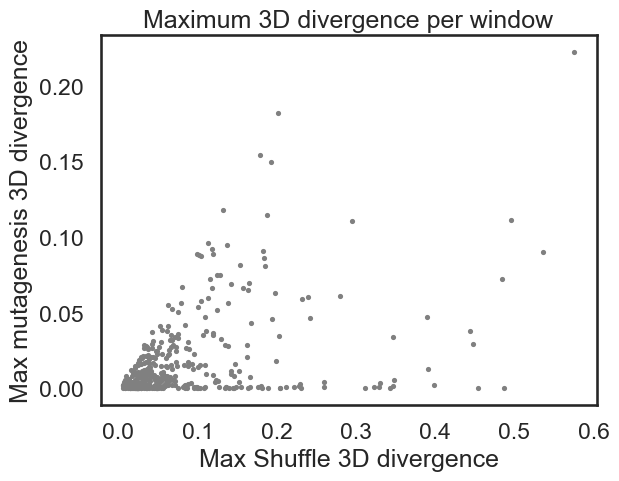

In [32]:
plt.scatter(emp['max_obs_div'], emp['max_ism_div'], s=5, color='grey')
plt.xlabel('Max Shuffle 3D divergence')
plt.ylabel('Max mutagenesis 3D divergence')
plt.title('Maximum 3D divergence per window')

Text(0.5, 1.0, 'Maximum 3D divergence per window')

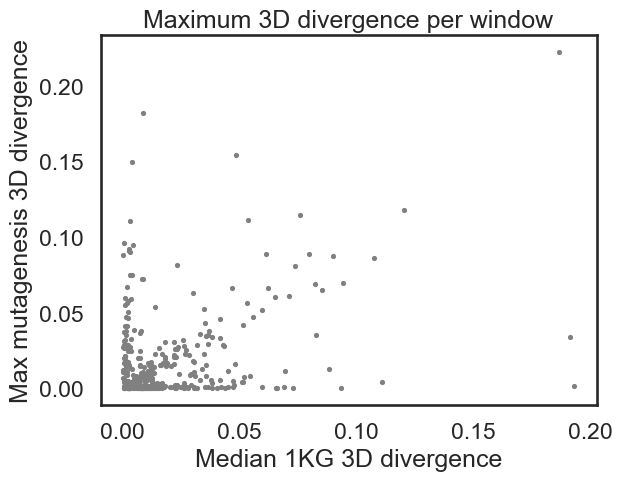

In [33]:
plt.scatter(emp['med_obs_div'], emp['max_ism_div'], s=5, color='grey')
plt.xlabel('Median 1KG 3D divergence')
plt.ylabel('Max mutagenesis 3D divergence')
plt.title('Maximum 3D divergence per window')

In [34]:
emp['percent_of_max'] = emp['max_ism_div'] / emp['max_obs_div']
emp['percent_of_med'] = emp['max_ism_div'] / emp['med_obs_div']

Text(0.5, 0, 'Percent of maximum observed divergence')

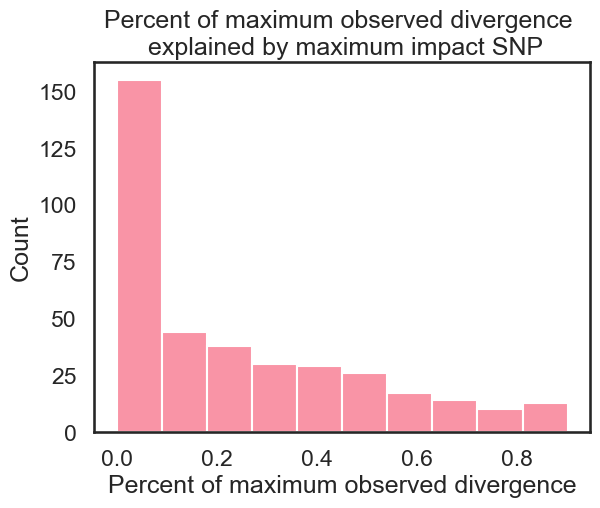

In [35]:
sns.histplot(emp['percent_of_max'])
plt.title('Percent of maximum observed divergence \n explained by maximum impact SNP')
plt.xlabel('Percent of maximum observed divergence')

Text(0.5, 1.0, 'x axis cut off at 2, (maximum is ~152)')

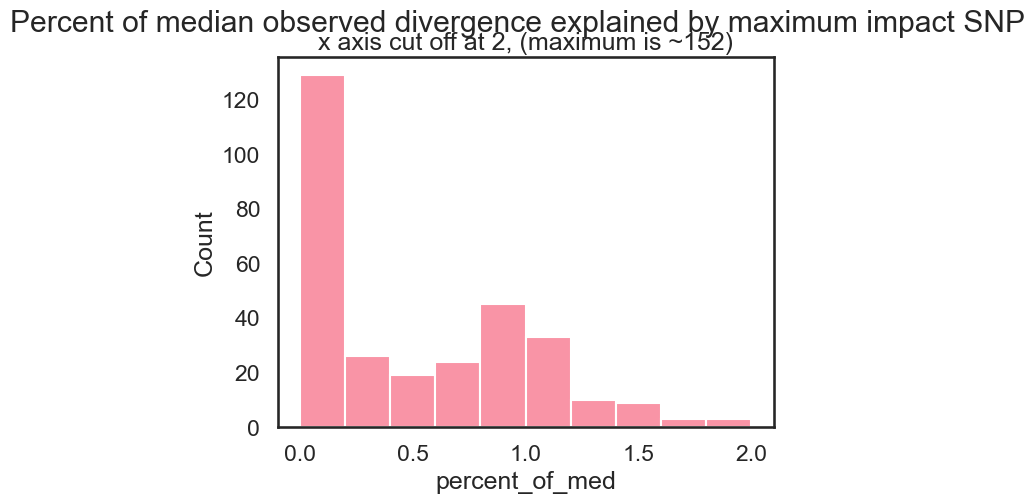

In [36]:
sns.histplot(emp['percent_of_med'], binrange=(0,2))
plt.suptitle('Percent of median observed divergence explained by maximum impact SNP')
plt.title('x axis cut off at 2, (maximum is ~152)')

In [37]:
emp.sort_values(by='max_ism_div', ascending=False)

ttest_stat     ttest_pval      obs_mean      exp_mean  \
chr   windowStartPos                                                          
chr7  125829120       -20.437908   6.091180e-87  1.205846e-01  1.491484e-02   
chr5  18350080         -9.039596   2.777394e-19  4.246237e-02  1.373628e-02   
chr2  35127296        -11.630032   1.333743e-30  5.238522e-02  2.436805e-02   
chr13 68681728         -5.261608   1.530183e-07  3.389068e-02  1.784575e-02   
chr10 96468992        -35.570247  5.990914e-231  9.083415e-02  7.102776e-03   
...                          ...            ...           ...           ...   
chr17 24117248        -41.280937  1.877199e-294  4.948939e-11  0.000000e+00   
chr18 17301504        -40.933797  1.648536e-290  8.030596e-11  0.000000e+00   
      19398656        -40.714949  4.995435e-288  5.817981e-11  0.000000e+00   
chr19 25165824        -41.497584  6.424500e-297  3.590249e-11  2.220446e-17   
      25690112        -41.489288  7.985836e-297  3.454752e-11  0.000000e+00   

                           obs/exp       obs-exp   -log10(p) direction   sig  \
chr   windowStartPos                                                           
chr7  125829120       8.084869e+00  1.056697e-01   86.215299    higher  True   
chr5  18350080        3.091258e+00  2.872609e-02   18.556363    higher  True   
chr2  35127296        2.149750e+00  2.801717e-02   29.874928    higher  True   
chr13 68681728        1.899089e+00  1.604493e-02    6.815257    higher  True   
chr10 96468992        1.278854e+01  8.373137e-02  230.222507    higher  True   
...                            ...           ...         ...       ...   ...   
chr17 24117248                 inf  4.948939e-11  293.726490    higher  True   
chr18 17301504                 inf  8.030596e-11  289.782901    higher  True   
      19398656                 inf  5.817981e-11  287.301427    higher  True   
chr19 25165824        1.616904e+06  3.590246e-11  296.192161    higher  True   
      25690112                 inf  3.454752e-11  296.097680    higher  True   

                      numWindowsAbove  ...           AMR       min  \
chr   windowStartPos                   ...                           
chr7  125829120                    19  ...  1.047728e-01  0.000669   
chr5  18350080                      0  ...  4.429541e-02  0.004546   
chr2  35127296                      0  ...  3.765436e-02  0.001160   
chr13 68681728                      0  ...  3.822095e-02  0.001357   
chr10 96468992                      0  ...  6.727453e-02  0.000326   
...                               ...  ...           ...       ...   
chr17 24117248                   1903  ...  5.163030e-11  0.000000   
chr18 17301504                   1903  ...  8.318346e-11  0.000000   
      19398656                   1903  ...  6.039959e-11  0.000000   
chr19 25165824                   1903  ...  3.720297e-11  0.000000   
      25690112                   1903  ...  3.584570e-11  0.000000   

                               max   emp_min       emp_max  max_ism_div  \
chr   windowStartPos                                                      
chr7  125829120       5.752178e-01  0.000000  5.091931e-01     0.222205   
chr5  18350080        2.019340e-01  0.000672  3.625176e-01     0.181841   
chr2  35127296        1.787666e-01  0.000737  2.405862e-01     0.154261   
chr13 68681728        1.934238e-01  0.000358  5.014548e-01     0.149404   
chr10 96468992        1.323995e-01  0.000313  1.339358e-01     0.118073   
...                            ...       ...           ...          ...   
chr17 24117248        6.748357e-11  0.000000  0.000000e+00          NaN   
chr18 17301504        1.058902e-10  0.000000  0.000000e+00          NaN   
      19398656        7.786360e-11  0.000000  0.000000e+00          NaN   
chr19 25165824        4.670242e-11  0.000000  1.110223e-16          NaN   
      25690112        4.511558e-11  0.000000  0.000000e+00          NaN   

                       max_obs_div   med_obs_div  percent_of_max  

In [38]:
ism[ism.chr=='chr5'][ism.window==18350080].sort_values(by='1-spearman', ascending=False)

/var/folders/h7/skbyg_hd0lb0s5rwqt8vxx4r0000gn/T/ipykernel_60904/93828037.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ism[ism.chr=='chr5'][ism.window==18350080].sort_values(by='1-spearman', ascending=False)


,chr,pos,window,ref,alt,mse,1-pearson,1-spearman
559986,chr5,18466287,18350080,G,A,6.451819e-03,1.760998e-01,1.818409e-01
559988,chr5,18466291,18350080,C,T,3.076718e-04,8.274816e-03,7.123966e-03
560898,chr5,18698753,18350080,G,A,5.899011e-05,1.091199e-03,9.489403e-04
561939,chr5,19073830,18350080,C,T,1.150433e-05,2.995418e-04,3.063073e-04
561112,chr5,18772502,18350080,G,A,8.076083e-06,1.763061e-04,1.642567e-04
...,...,...,...,...,...,...,...,...
562762,chr5,19393553,18350080,A,T,3.002246e-11,8.051692e-10,1.555161e-09
559168,chr5,18350702,18350080,T,C,3.115424e-11,8.280647e-10,1.359380e-09
559226,chr5,18353689,18350080,T,G,2.317990e-11,6.438458e-10,1.225000e-09
559178,chr5,18351494,18350080,A,T,2.383351e-11,6.385528e-10,1.150640e-09


In [39]:
ism[ism.chr=='chr7'][ism.window==125829120].sort_values(by='1-spearman', ascending=False)

/var/folders/h7/skbyg_hd0lb0s5rwqt8vxx4r0000gn/T/ipykernel_60904/3714539931.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ism[ism.chr=='chr7'][ism.window==125829120].sort_values(by='1-spearman', ascending=False)


,chr,pos,window,ref,alt,mse,1-pearson,1-spearman
673005,chr7,126645389,125829120,C,T,4.075127e-03,2.227842e-01,2.222050e-01
671745,chr7,126380660,125829120,T,C,1.053948e-04,4.610999e-03,6.877434e-03
671987,chr7,126429689,125829120,G,A,3.524182e-06,1.881530e-04,2.562810e-04
671741,chr7,126380533,125829120,T,C,3.946468e-06,1.827399e-04,2.519270e-04
671973,chr7,126426824,125829120,A,G,3.005384e-06,1.659801e-04,2.311829e-04
...,...,...,...,...,...,...,...,...
670430,chr7,125837435,125829120,C,T,4.152158e-11,2.068876e-09,3.385562e-09
670500,chr7,125861769,125829120,C,T,2.736654e-11,1.395125e-09,2.801691e-09
673813,chr7,126868435,125829120,G,A,5.813134e-11,2.960177e-09,2.678045e-09
673817,chr7,126871966,125829120,T,C,2.970402e-11,1.446840e-09,2.120656e-09


In [40]:
0.2222 / 0.5752

0.38630041724617525

In [41]:
anc_controls = ism.sort_values(by=['1-spearman'], ascending=True).head(100)
anc_controls = anc_controls[['chr','pos','ref','alt','1-spearman']]

anc_controls.to_csv('ancestral_controls.txt', sep='\t', index=False)

In [42]:
anc_mods = ism[ism['1-spearman']>=0.001]
anc_mods = anc_mods[['chr','pos','ref','alt','1-spearman']]
anc_mods.to_csv('ancestral_3D_modifying.txt', sep='\t', index=False)

In [43]:
anc_controls

,chr,pos,ref,alt,1-spearman
577774,chr5,71827457,C,T,1.849754e-11
282898,chr19,14155749,T,G,4.166845e-11
220274,chr16,89128971,A,G,4.692058e-11
508638,chr4,114294784,G,C,5.291789e-11
131731,chr12,107482977,T,C,6.268297e-11
...,...,...,...,...,...
248896,chr18,5216736,T,C,2.538245e-10
406193,chr20,47691577,G,A,2.540332e-10
233687,chr17,30417754,C,G,2.546906e-10
525934,chr4,164628613,A,G,2.566868e-10


## Additive effects

In [44]:
ism_dict[('chr1',
  41418752)]['1-spearman'].sum()

0.015445614110028547

In [45]:
emp

ttest_stat     ttest_pval  obs_mean  exp_mean   obs/exp  \
chr   windowStartPos                                                            
chr1  41418752        -26.987165  1.461871e-143  0.011143  0.003190  3.492743   
      57147392        -11.867927   9.060743e-32  0.021517  0.007885  2.728665   
      70778880         -5.334215   1.032114e-07  0.003761  0.002849  1.319976   
      88604672        -17.578602   7.272380e-66  0.014955  0.002522  5.929643   
      92798976        -16.384539   8.147811e-58  0.071182  0.008426  8.447434   
...                          ...            ...       ...       ...       ...   
chr21 35127296         -8.395653   7.093248e-17  0.030532  0.022997  1.327648   
chr22 22020096        -10.467888   3.332675e-25  0.023887  0.017606  1.356793   
      22544384         -9.387509   1.188089e-20  0.011776  0.007743  1.520958   
      47710208        -26.485256  7.297025e-139  0.055388  0.020211  2.740559   
      48234496        -55.442420   0.000000e+00  0.204145  0.035823  5.698711   

                       obs-exp   -log10(p) direction   sig  numWindowsAbove  \
chr   windowStartPos                                                          
chr1  41418752        0.007953  142.835091    higher  True                2   
      57147392        0.013631   31.042836    higher  True                1   
      70778880        0.000912    6.986272    higher  True                0   
      88604672        0.012433   65.138323    higher  True                7   
      92798976        0.062755   57.088959    higher  True                0   
...                        ...         ...       ...   ...              ...   
chr21 35127296        0.007535   16.149155    higher  True                0   
chr22 22020096        0.006282   24.477207    higher  True                0   
      22544384        0.004034   19.925151    higher  True                0   
      47710208        0.035178  138.136854    higher  True                0   
      48234496        0.168322         inf    higher  True              367   

                      ...       AMR       min       max   emp_min   emp_max  \
chr   windowStartPos  ...                                                     
chr1  41418752        ...  0.008076  0.000214  0.061708  0.000240  0.047160   
      57147392        ...  0.036207  0.000460  0.241914  0.000711  0.198873   
      70778880        ...  0.003891  0.000125  0.015220  0.000125  0.071377   
      88604672        ...  0.014783  0.000098  0.068938  0.000080  0.055810   
      92798976        ...  0.074693  0.000381  0.260017  0.000371  0.454930   
...                   ...       ...       ...       ...       ...       ...   
chr21 35127296        ...  0.030236  0.008522  0.120146  0.001044  0.323117   
chr22 22020096        ...  0.022474  0.001957  0.055087  0.001038  0.190579   
      22544384        ...  0.009572  0.000380  0.032310  0.000370  0.141347   
      47710208        ...  0.059584  0.001600  0.142327  0.001173  0.203276   
      48234496        ...  0.219469  0.002814  0.346398  0.002023  0.280502   

                      max_ism_div  max_obs_div  med_obs_div  percent_of_max  \
chr   windowStartPos                                                          
chr1  41418752           0.013818     0.061708     0.013622        0.223924   
      57147392           0.046179     0.241914     0.002589        0.190889   
      70778880           0.004463     0.015220     0.003781        0.293259   
      88604672           0.028706     0.068938     0.000810        0.416400   
      92798976           0.000728     0.260017     0.001733        0.002798   
...                           ...          ...          ...             ...   
chr21 35127296           0.008852     0.120146     0.029215        0.073674   
chr22 22020096           0.009399     0.055087     0.024408        0.170624   
      22544384           0.006354     0.032310     0.012853        0.196670   
      47710208           0.011125     0.142

In [46]:
additive = []
for w in ism_dict.keys():
    additive.append(ism_dict[w]['1-spearman'].sum())

In [47]:
emp['ism_sum'] = additive

In [48]:
emp['additive_percent_of_max'] = emp['ism_sum'] / emp['max_obs_div']

Text(0.5, 0, 'Percent of maximum observed divergence')

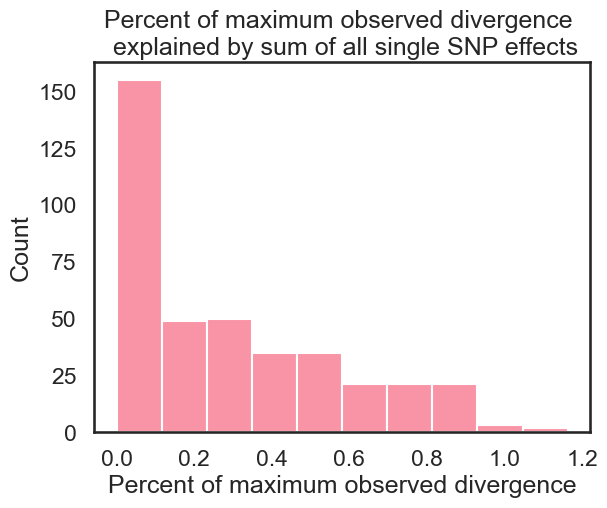

In [49]:
sns.histplot(emp['additive_percent_of_max'])
plt.title('Percent of maximum observed divergence \n explained by sum of all single SNP effects')
plt.xlabel('Percent of maximum observed divergence')

## Annotate 3D disrupting variants

### ID disrupting variants

In [3]:
def get_mod_vars(thresh):
    mod_vars = pd.DataFrame(columns = ism.columns)
    for w in ism_dict.keys():
        df = ism_dict[w]
        df = df[df['percent_of_max_observed'] > thresh]
        if df.shape[0] != 0:
            mod_vars = pd.concat([mod_vars, df])
    mod_vars['pos-1'] = mod_vars['pos'] -1
    mod_vars = mod_vars[['chr','pos-1', 'pos','window','ref','alt','percent_of_max_observed', '1-spearman']]
    return mod_vars


### genomic annotations

In [ ]:
ctcf = pybedtools.BedTool('%s/annotations/ctcf_full_merged_hg38.bed' % DATA_PATH).merge()
genes = pybedtools.BedTool('%s/annotations/grch38_gene_annotations.bed' % DATA_PATH)
phylop=pd.read_table('%s/annotations/phylop_divergent_windows_3dmod10_variants.txt' % DATA_PATH)
phylop['start'] = phylop['start'] - 1
tag = pd.read_table('%s/annotations/Inversion_tagging_SNPs_indels.txt' % DATA_PATH, skiprows=[0,1], names = ['Inversion','rsid','chr','pos_hg19','tagging_allele',
                                                                                                               'LWK_1kg', 'YRI_1kg', 'CHB_1kg', 'JPT_1kg', 'CEU_1kg', 'TSI_1kg', 'GIH_1kg', 'AFR_1kg', 'EAS_1kg', 'EUR_1kg', 'GLB_1kg',
                                                                                                               'LWK_hapmap', 'YRI_hapmap', 'CHB_hapmap', 'JPT_hapmap', 'CEU_hapmap', 'TSI_hapmap', 'GIH_hapmap', 'AFR_hapmap', 'EAS_hapmap', 'EUR_hapmap', 'GLB_hapmap'])
tag = tag.drop(columns=['LWK_hapmap', 'YRI_hapmap', 'CHB_hapmap', 'JPT_hapmap', 'CEU_hapmap', 'TSI_hapmap', 'GIH_hapmap', 'AFR_hapmap', 'EAS_hapmap', 'EUR_hapmap', 'GLB_hapmap'])
tag = tag[(tag.tagging_allele.apply(lambda x: len(str(x))==1))]

hg38_tag = pd.read_table('%s/annotations/gen_coords_938907ca.txt' % DATA_PATH)

tag_merge = hg38_tag.merge(tag, left_on='dbSNP', right_on='rsid')
tag_merge['-1'] = tag_merge['Position'] - 1
tag_bed = tag_merge[['chr','-1','Position']]
tag_bed['chr'] = 'chr' + tag_bed['chr'].astype(str)


In [ ]:
def annot_vars(mod_vars, name):
    mod_vars_annot = BedTool.from_dataframe(mod_vars).intersect(ctcf, wao=True).to_dataframe(disable_auto_names=True, header=None)
    mod_vars_annot.columns = list(mod_vars.columns) + ['elem_chr','elem_start','elem_stop','ctcf']
    mod_vars_annot = mod_vars_annot[list(mod_vars.columns) + ['ctcf']]

    mod_vars_annot = BedTool.from_dataframe(mod_vars_annot).intersect(genes, wao=True).to_dataframe(disable_auto_names=True, header=None)
    mod_vars_annot.columns = list(mod_vars.columns) + ['ctcf'] + ['elem_chr','elem_start','elem_stop','gene_name','genes']
    mod_vars_annot = mod_vars_annot[list(mod_vars.columns) + ['ctcf', 'gene_name','genes']]
    mod_vars_annot = mod_vars_annot.drop_duplicates(subset = list(mod_vars.columns), ignore_index=True)

    

    mod_vars_annot['phylop'] = phylop['Mean']

    total_bases = mod_vars_annot.shape[0]

    annots = ['Genes','CTCF', 'Conserved Bases \n (PhyloP)']
    #1 = conserved phylop> 0 , 0 = fast evolving, phylop<0
    annot_counts = {'Yes': [mod_vars_annot[mod_vars_annot.genes==1].shape[0]/total_bases, mod_vars_annot[mod_vars_annot.ctcf==1].shape[0]/total_bases, mod_vars_annot[mod_vars_annot.phylop>0].shape[0]/total_bases], 
                    'No':[ mod_vars_annot[mod_vars_annot.genes==0].shape[0]/total_bases, mod_vars_annot[mod_vars_annot.ctcf==0].shape[0]/total_bases, mod_vars_annot[mod_vars_annot.phylop<0].shape[0]/total_bases]}

    width = 0.5

    fig, ax = plt.subplots(figsize=(7,7))
    bottom = np.zeros(3)

    for boolean, annot_counts in annot_counts.items():
        p = ax.bar(annots, annot_counts, width, label=boolean, bottom=bottom)
        bottom += annot_counts
    
    plt.ylim(0,1.05)
    plt.ylabel('Proportion of 3D modifying variants')
    ax.legend(loc="best", bbox_to_anchor=(.8, 0., 0.5, 0.8))
    plt.title("Variants explaining at least %s percent of maximum divergence (n = %s)" % (name, mod_vars_annot.shape[0]))
    plt.savefig("%s/sup/ism_common_cutoff_%s.svg" % (FIG_PATH, name), bbox_inches = 'tight')
    plt.show()
    return mod_vars_annot

In [ ]:
# for row in mod_vars_10.index:
#     chr = mod_vars_10.loc[row]['chr']
#     start = mod_vars_10.loc[row]['pos-1']
#     end = mod_vars_10.loc[row]['pos']
#     print(chr, start, end)

In [ ]:
mod_vars_10 = get_mod_vars(0.1)
mod_vars_annot_10 = annot_vars(mod_vars_10, "10")


mod_vars_20 = get_mod_vars(0.2)
mod_vars_annot_20 = annot_vars(mod_vars_20, "20")

mod_vars_50 = get_mod_vars(0.5)
mod_vars_annot_50 = annot_vars(mod_vars_50, "50")

mod_vars_80 = get_mod_vars(0.8)
mod_vars_annot_80 = annot_vars(mod_vars_80, "80")

In [ ]:
mod_vars_annot_10

In [ ]:
mod_vars_annot = mod_vars_annot_20
mod_vars_annot = BedTool.from_dataframe(mod_vars_annot).intersect(BedTool.from_dataframe(tag_bed), wao=True).to_dataframe(disable_auto_names=True, header=None)
mod_vars_annot
# mod_vars_annot.columns = list(mod_vars.columns) + ['ctcf', 'phylop'] + ['elem_chr','elem_start','elem_stop','gene_name','genes']
# mod_vars_annot = mod_vars_annot[list(mod_vars.columns) + ['ctcf', 'gene_name','genes']]
# mod_vars_annot = mod_vars_annot.drop_duplicates(subset = list(mod_vars.columns), ignore_index=True)

In [ ]:
hg38_tag

# IDWs

## choose variants for IDW mutagenesis

In [ ]:
comp_list = pd.read_csv('%s/comp_tables/pairwise_subsample_genomewide_averages.csv' % RESULTS_PATH,
                       index_col=0)
all_indivs = sorted(list(set(comp_list.ind1.unique()) | set(comp_list.ind2.unique())))

In [ ]:
comp_list

In [ ]:
indivs = comp_list[['ind1','super1','sub1','sex1','ind1.1']]
indivs = indivs.drop_duplicates()
extra_ind = comp_list[comp_list.ind2 == 'EUR_CEU_female_NA12046'][['ind2','super2','sub2','sex2','ind2.2']].drop_duplicates()
extra_ind.columns = indivs.columns
indivs = pd.concat([indivs, extra_ind], axis=0, ignore_index=True)

In [ ]:
indivs = pd.DataFrame(columns = ['name','super','sub','sex','id'])
for i in all_indivs:
    if i in list(comp_list['ind1']):
        new = comp_list[comp_list.ind1 == i][['ind1','super1','sub1','sex1','ind1.1']].drop_duplicates()
    elif i in list(comp_list['ind2']):
        new = comp_list[comp_list.ind2 == i][['ind2','super2','sub2','sex2','ind2.2']].drop_duplicates()
    new.columns = indivs.columns
    indivs = pd.concat([indivs, new], axis=0, ignore_index=True)


In [ ]:
indivs


In [ ]:
vcf_header = pd.read_table('%s/vcfs/vcf_header.txt' % DATA_PATH, header=None, usecols=[i for i in range(9,2557)])
vcf_header = vcf_header.T.reset_index()

In [ ]:
vcf_header['index'] = vcf_header['index']-5

In [ ]:
vcf_header[vcf_header[0] =='HG04183']

In [ ]:
indivs

In [ ]:
vcf_header[vcf_header[0]=='NA12878']

In [ ]:
indivs = indivs.merge(vcf_header, left_on='id', right_on=0).sort_values(by='index')

In [ ]:
indivs

In [ ]:
indivs.to_csv('%s/vcfs/vcf_indexing.txt' % DATA_PATH)

In [ ]:
a = list(indivs['index']+1)

In [ ]:
a.sort()

In [ ]:
a

In [ ]:
indivs

In [ ]:
idw_vars_non_ref = pd.read_table("%s/IDWs/IDW_variants_non-ref.txt" % DATA_PATH, header=None, names = ['chr', 'pos', 'ref', 'alt', 'window_start'])
idw_vars_non_ref['window_start'] = idw_vars_non_ref['window_start'] + 1
idw_vars_ref = pd.read_table("%s/IDWs/IDW_variants_ref.txt" % DATA_PATH, header=None, names = ['chr', 'pos', 'ref', 'alt', 'window_start'])
idw_vars_ref['window_start'] = idw_vars_ref['window_start'] + 1

In [ ]:
idw_vars_non_ref['chr'] = 'chr' + idw_vars_non_ref['chr'].astype(str)

In [ ]:
idw_vars_ref['chr'] = 'chr' + idw_vars_ref['chr'].astype(str)

In [ ]:
idw_vars_non_ref[idw_vars_non_ref.chr=='chr1'].sort_values(by='pos')

In [ ]:
idw_vars_non_ref.to_csv('%s/in_silico_mutagenesis/variants_in_divergent_windows_idw_non_ref.txt' % DATA_PATH, sep='\t', header=False, index=False)

In [ ]:
idw_vars_ref.to_csv('%s/in_silico_mutagenesis/variants_in_divergent_windows_idw_ref.txt' % DATA_PATH, sep='\t', header=False, index=False)

In [ ]:
idw_vars_non_ref.chr.unique()


## few windows, all variants

In [ ]:
chr3_HG04183 = pd.read_table('%s/in_silico_mutagenesis/all_variants_few_windows/chr3_one_zero_genotypes.txt' % DATA_PATH, names =['chr','pos','ref','alt','status'])
chr3_HG04183['window'] = 174587904
chr3_HG04183['chr'] = 'chr' + chr3_HG04183['chr'].apply(str)
chr3_HG04183 = chr3_HG04183[chr3_HG04183.status>0].loc[chr3_HG04183['ref'].str.len() == 1].loc[chr3_HG04183['alt'].str.len() == 1][['chr','pos','ref','alt','window']]
chr3_HG04183.to_csv('%s/IDWs/chr3_HG04183_variants.txt' % DATA_PATH, sep='\t', header=None, index=False)


In [ ]:
chr3_HG04183 = chr3_HG04183.reset_index(drop=True)
chr3_HG04183[chr3_HG04183.pos==175288067]

In [ ]:
chr4_HG00864 = pd.read_table('%s/in_silico_mutagenesis/all_variants_few_windows/chr4_one_zero_genotypes.txt' % DATA_PATH, names =['chr','pos','ref','alt','status'])
chr4_HG00864['window'] = 27262976
chr4_HG00864['chr'] = 'chr' + chr4_HG00864['chr'].apply(str)
chr4_HG00864 = chr4_HG00864[chr4_HG00864.status>0].loc[chr4_HG00864['ref'].str.len() == 1].loc[chr4_HG00864['alt'].str.len() == 1][['chr','pos','ref','alt','window']]
chr4_HG00864.to_csv('%s/IDWs/chr4_HG00864_variants.txt' % DATA_PATH, sep='\t', header=None, index=False)


In [ ]:
chr4_HG00864 = chr4_HG00864.reset_index(drop=True)
chr4_HG00864[chr4_HG00864.pos==28251340]


In [ ]:
chr4_HG00864

In [ ]:
chr14_HG02946 = pd.read_table('%s/in_silico_mutagenesis/all_variants_few_windows/chr14_one_zero_genotypes.txt' % DATA_PATH, names =['chr','pos','ref','alt','status'])
chr14_HG02946['window'] = 46137344
chr14_HG02946['chr'] = 'chr' + chr14_HG02946['chr'].apply(str)
chr14_HG02946 = chr14_HG02946[chr14_HG02946.status>0].loc[chr14_HG02946['ref'].str.len() == 1].loc[chr14_HG02946['alt'].str.len() == 1][['chr','pos','ref','alt','window']]
chr14_HG02946.to_csv('%s/IDWs/chr14_HG02946_variants.txt' % DATA_PATH, sep='\t', header=None, index=False)


In [ ]:
chr14_HG02946 = chr14_HG02946.reset_index(drop=True)
chr14_HG02946[chr14_HG02946.pos==46707124]

In [ ]:
chr14_HG02946



## load in mutagenesis files and set up dictionary data structure

run in command line for bash script
```
head -n 1 ism_scores_idw_rare_alternate_1.txt > ism_scores_idw_rare_alternate_all.txt
for i in {1..25}; do tail -n +2 ism_scores_idw_rare_alternate_$i.txt >> div.tmp; done
sort -k1,1 -k2n,2 div.tmp >> ism_scores_idw_rare_alternate_all.txt
rm div.tmp
```

## Rare alternate allele

In [3]:
ism = pd.read_table('%s/in_silico_mutagenesis/IDW/all_indivs/ism_scores_idw_rare_alternate_all.txt' % DATA_PATH)
# ancestral 3D dataframes
anc_spear = pd.read_table('%s/comp_tables/anc_window_spearman.csv' % RESULTS_PATH
                    , sep=',', header=[0,1,2,3], index_col=[0,1])
anc_div = 1-anc_spear

ref_spear = pd.read_table('%s/comp_tables/ref_window_spearman.csv' % RESULTS_PATH
                    , sep=',', header=[0,1,2,3], index_col=[0,1])
ref_div = 1-ref_spear


In [4]:
idw_list = pd.read_table("%s/IDWs/all_indivs/idw_mut_params_all.txt" % DATA_PATH, names = ['vcf_col_id','chr','window_start','window_end','individual', 'depth'])
idw_list.index = list(zip(idw_list.chr, idw_list.window_start))


In [5]:
idw_list.sort_values(by='vcf_col_id')

,vcf_col_id,chr,window_start,window_end,individual,depth
"(chr7, 49283072)",6,chr7,49283072,50331648,EUR_GBR_female_HG00099,0.068204
"(chr6, 85458944)",7,chr6,85458944,86507520,EUR_GBR_female_HG00100,0.008265
"(chr2, 56098816)",12,chr2,56098816,57147392,EUR_GBR_female_HG00106,0.375586
"(chr2, 56623104)",12,chr2,56623104,57671680,EUR_GBR_female_HG00106,0.174196
"(chr2, 180355072)",14,chr2,180355072,181403648,EUR_GBR_male_HG00108,0.009205
...,...,...,...,...,...,...
"(chr22, 45088768)",2450,chr22,45088768,46137344,SAS_GIH_female_NA20908,0.050071
"(chr16, 84410368)",2450,chr16,84410368,85458944,SAS_GIH_female_NA20908,0.022333
"(chr6, 131596288)",2458,chr6,131596288,132644864,SAS_GIH_male_NA21091,0.017677
"(chr15, 35127296)",2458,chr15,35127296,36175872,SAS_GIH_male_NA21091,0.267321


In [6]:
idw_list.groupby(by=['chr','window_start']).max()

vcf_col_id  window_end              individual     depth
chr  window_start                                                          
chr1 3670016              614     4718592  EUR_IBS_female_HG01784  0.143493
     4194304              614     5242880  EUR_IBS_female_HG01784  0.250229
     5242880             2146     6291456    AFR_LWK_male_NA19443  0.008815
     6291456              266     7340032    EAS_CHS_male_HG00631  0.033725
     8388608             1614     9437184  SAS_BEB_female_HG04144  0.232977
...                       ...         ...                     ...       ...
chr9 126353408            694   127401984  AMR_PEL_female_HG01921  0.039006
     126877696            694   127926272  AMR_PEL_female_HG01921  0.098473
     127401984            999   128450560    AFR_GWD_male_HG02588  0.020658
     128450560           1420   129499136    SAS_STU_male_HG03740  0.019458
     132644864           1699   133693440    EUR_CEU_male_NA12144  0.030289

[1494 rows x 4 columns]

In [7]:
ism

,chr,pos,window,ref,alt,mse,1-pearson,1-spearman
0,chr1,3906648,3670016,A,G,1.884940e-07,3.551339e-07,1.387478e-06
1,chr1,4112652,3670016,A,G,1.272000e-07,2.648918e-07,1.885666e-06
2,chr1,4119233,3670016,A,G,1.208718e-09,2.509213e-09,1.824087e-08
3,chr1,4324220,3670016,G,A,2.758847e-08,5.253254e-08,4.683371e-07
4,chr1,4324220,4194304,G,A,1.271432e-08,2.380734e-07,3.569042e-07
...,...,...,...,...,...,...,...,...
12170,chr9,133215850,132644864,G,A,7.391380e-08,1.250904e-07,1.616058e-07
12171,chr9,133223412,132644864,C,T,1.776799e-07,3.817101e-07,4.669487e-07
12172,chr9,133470349,132644864,G,A,3.112274e-07,5.441187e-07,5.246929e-07
12173,chr9,133527545,132644864,A,T,6.750516e-08,1.321467e-07,1.444451e-07


In [10]:
ism = ism.dropna()

In [11]:
ism.groupby(by=['chr','window']).max()

pos ref alt       mse  1-pearson  1-spearman
chr  window                                                       
chr1 3670016      4699446   T   T  0.007868   0.016152    0.087570
     4194304      5000546   T   T  0.006578   0.131016    0.161669
     5242880      6263363   T   T  0.001882   0.003685    0.004415
     6291456      7188302   T   T  0.012015   0.018828    0.019941
     8388608      9346895   T   T  0.018312   0.082096    0.101057
...                   ...  ..  ..       ...        ...         ...
chr9 126353408  127349911   G   T  0.015153   0.028130    0.030993
     126877696  127778552   G   T  0.013941   0.047179    0.050510
     127401984  128265086   T   T  0.007259   0.012670    0.014144
     128450560  129467352   T   T  0.005359   0.009218    0.015322
     132644864  133686097   G   T  0.012063   0.024378    0.025450

[1494 rows x 6 columns]

In [12]:
ism.sort_values(by='1-spearman')

,chr,pos,window,ref,alt,mse,1-pearson,1-spearman
10935,chr7,101789061,101711872,G,A,3.193928e-11,4.214018e-11,1.853259e-10
9743,chr6,37747882,36700160,A,G,4.589999e-11,8.023726e-11,2.460431e-10
12167,chr9,129467352,128450560,T,C,6.408771e-11,1.077008e-10,2.520736e-10
5793,chr2,154107281,153092096,A,G,6.349716e-12,8.578871e-11,3.222864e-10
12107,chr9,121659124,121634816,C,T,1.009602e-10,1.341052e-10,3.644275e-10
...,...,...,...,...,...,...,...,...
3128,chr14,26984744,26214400,C,T,1.674006e-02,3.419717e-01,3.854835e-01
8472,chr4,156475471,155713536,C,T,2.741319e-02,3.428150e-01,4.112895e-01
7975,chr4,35357289,34603008,G,C,1.358040e-02,4.343157e-01,4.253111e-01
7438,chr3,106609897,105906176,C,G,6.513783e-02,5.840132e-01,5.125214e-01


### comparing to reference

In [13]:
max_divs = []
all_percs = []
ism_dict = {}
max_os = {}
for i in idw_list.index:
    r = ref_div.loc[i]
    ind = idw_list.loc[[i]].individual[0]
    # if ind.split("_")[3] == 'HG02069':
    #     continue
    max_o = r[ind.split("_")[0]][ind.split("_")[1]][ind.split("_")[2]][ind.split("_")[3]]
    chr = i[0]
    window = i[1]
    arry = ism[ism.chr==chr][ism.window==window]
    if arry.shape[0]>0:
        max_os[i] = max_o
        arry['percent_of_max_observed'] = arry['1-spearman']/max_o
        max_divs.append(arry['1-spearman'].max())
        ism_dict[i] = arry
        all_percs = all_percs + list(arry['percent_of_max_observed'])

/var/folders/h7/skbyg_hd0lb0s5rwqt8vxx4r0000gn/T/ipykernel_78134/4109648619.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ind = idw_list.loc[[i]].individual[0]
/var/folders/h7/skbyg_hd0lb0s5rwqt8vxx4r0000gn/T/ipykernel_78134/4109648619.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  arry = ism[ism.chr==chr][ism.window==window]
/var/folders/h7/skbyg_hd0lb0s5rwqt8vxx4r0000gn/T/ipykernel_78134/4109648619.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ind = idw_list.loc[[i]].individual[0]
/var/folders/h7/skbyg_hd0lb0s5rwqt8vxx4r0000gn/T/ipykernel_78134/4109648619.py:13: Use

Text(0, 0.5, 'Number of SNPs')

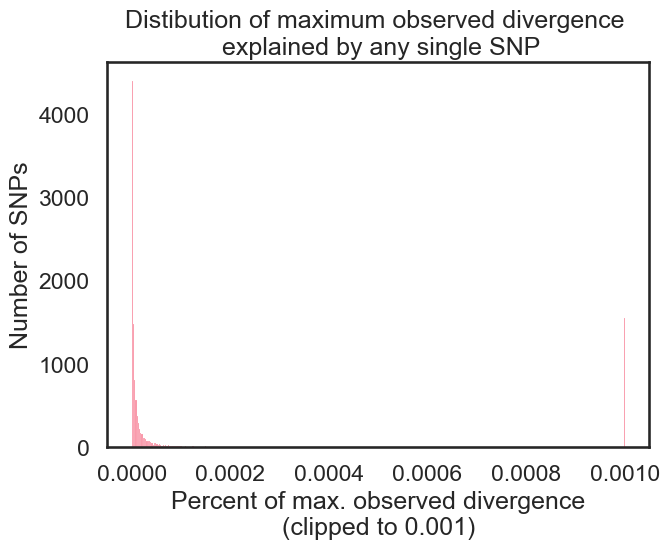

In [14]:
all_percs_clip = np.array(all_percs).clip(0,.0010)

plt.figure(figsize=(7,5))
sns.histplot(all_percs_clip)
plt.title('Distibution of maximum observed divergence \n explained by any single SNP')
plt.xlabel('Percent of max. observed divergence\n(clipped to 0.001)')
plt.ylabel('Number of SNPs')

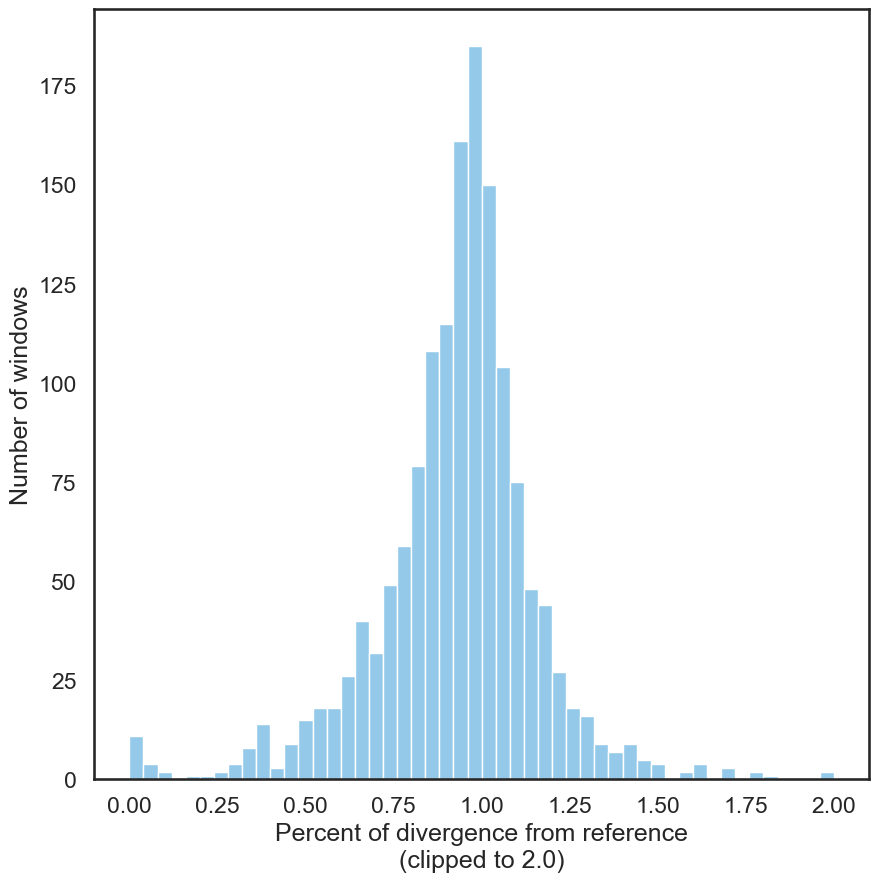

In [15]:
max_snp = []
for w in ism_dict.keys():
    max_snp.append(ism_dict[w]['percent_of_max_observed'].max())
    
max_snp = np.array(max_snp).clip(0,2)

plt.figure(figsize=(10,10))
sns.histplot(max_snp, bins=50, color='#71B7E4')
#plt.title('Percent of divergence from reference\nexplained by maximum impact SNP')
plt.xlabel('Percent of divergence from reference\n(clipped to 2.0)')
plt.ylabel('Number of windows')
plt.savefig("%s/idw_ism_hist.svg" % FIG_PATH, bbox_inches = 'tight')

Text(0, 0.5, 'Number of windows')

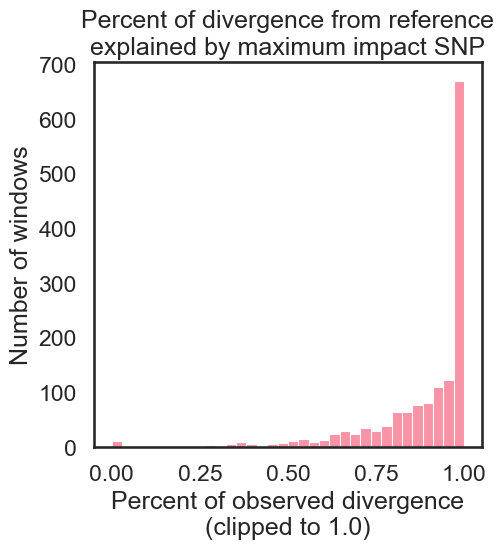

In [16]:
max_snp = []
for w in ism_dict.keys():
    max_snp.append(ism_dict[w]['percent_of_max_observed'].max())
    
max_snp = np.array(max_snp).clip(0,1)

plt.figure(figsize=(5,5))
sns.histplot(max_snp)
plt.title('Percent of divergence from reference\nexplained by maximum impact SNP')
plt.xlabel('Percent of observed divergence\n(clipped to 1.0)')
plt.ylabel('Number of windows')

Text(0, 0.5, 'Number of windows')

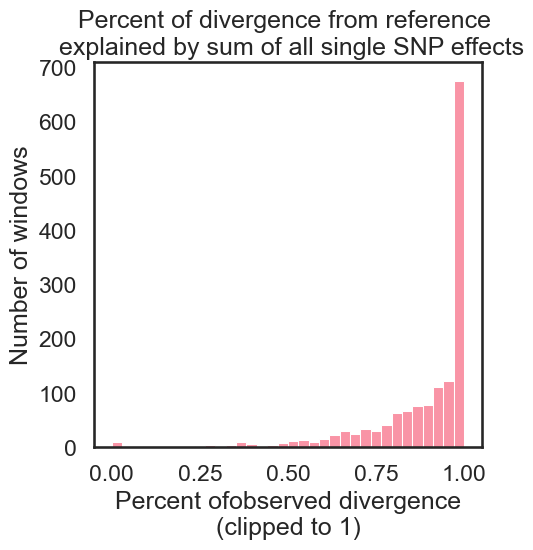

In [17]:
additive = []
for w in ism_dict.keys():
    additive.append(ism_dict[w]['percent_of_max_observed'].sum())
    
additive = np.array(additive).clip(0,1)

plt.figure(figsize=(5,5))
sns.histplot(additive)
plt.title('Percent of divergence from reference \n explained by sum of all single SNP effects')
plt.xlabel('Percent ofobserved divergence\n(clipped to 1)')
plt.ylabel('Number of windows')

Text(0, 0.5, 'Number of windows')

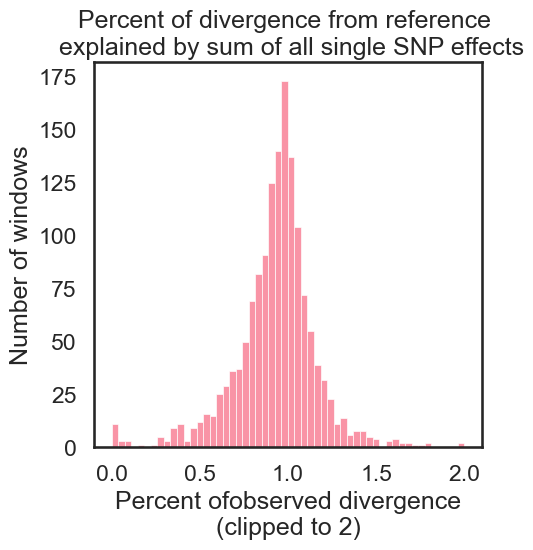

In [18]:
additive = []
for w in ism_dict.keys():
    additive.append(ism_dict[w]['percent_of_max_observed'].sum())
    
additive = np.array(additive).clip(0,2)

plt.figure(figsize=(5,5))
sns.histplot(additive)
plt.title('Percent of divergence from reference \n explained by sum of all single SNP effects')
plt.xlabel('Percent ofobserved divergence\n(clipped to 2)')
plt.ylabel('Number of windows')

In [19]:
ref_mods = ism[ism['1-spearman']>0.001]
ref_mods = ref_mods[['chr','pos','ref','alt','1-spearman']]
ref_mods.to_csv('reference_3D_modifying.txt', sep='\t', index=False)

In [20]:
ref_controls = ism.sort_values(by=['1-spearman'], ascending=True).head(100)
ref_controls = ref_controls[['chr','pos','ref','alt','1-spearman']]
ref_controls.to_csv('reference_controls.txt', sep='\t', index=False)

## Annotate 3D disrupting variants

### ID disrupting variants

In [21]:
mod_vars_10 = get_mod_vars(0.1)
#mod_vars_annot_10 = annot_vars(mod_vars_10, "10")

mod_vars_20 = get_mod_vars(0.2)
#mod_vars_annot_20 = annot_vars(mod_vars_20, "20")

mod_vars_50 = get_mod_vars(0.5)
#mod_vars_annot_50 = annot_vars(mod_vars_50, "50")

mod_vars_80 = get_mod_vars(0.8)
#mod_vars_annot_80 = annot_vars(mod_vars_80, "80")

/var/folders/h7/skbyg_hd0lb0s5rwqt8vxx4r0000gn/T/ipykernel_78134/1224136074.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_vars = pd.concat([mod_vars, df])
/var/folders/h7/skbyg_hd0lb0s5rwqt8vxx4r0000gn/T/ipykernel_78134/1224136074.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_vars = pd.concat([mod_vars, df])
/var/folders/h7/skbyg_hd0lb0s5rwqt8vxx4r0000gn/T/ipykernel_78134/1224136074.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is d

In [22]:
mod_vars_10

,chr,pos-1,pos,window,ref,alt,percent_of_max_observed,1-spearman
5,chr1,4362812,4362813,3670016,A,G,0.941313,0.087570
6,chr1,4362812,4362813,4194304,A,G,0.964249,0.161669
47,chr1,6185977,6185978,5242880,C,T,0.817812,0.004415
57,chr1,6780389,6780390,6291456,T,C,0.752507,0.019941
66,chr1,8849088,8849089,8388608,G,A,1.007488,0.101057
...,...,...,...,...,...,...,...,...
6731,chr22,44081368,44081369,43515904,C,T,1.009643,0.013223
6745,chr22,44736026,44736027,44040192,C,T,0.908624,0.014861
6753,chr22,45435855,45435856,45088768,C,T,1.397371,0.041691
6761,chr22,46758987,46758988,46137344,G,C,0.672040,0.037364


In [31]:
for row in mod_vars_10.index[]:
    #chr15 39580357 39580358
    chr = mod_vars_10.loc[row]['chr']
    start = mod_vars_10.loc[row]['pos-1']
    end = mod_vars_10.loc[row]['pos']
    print(chr, start, end)

chr1 4362812 4362813
chr1 4362812 4362813
chr1 6185977 6185978
chr1 6780389 6780390
chr1 8849088 8849089
chr1 9110936 9110937
chr1 12081762 12081763
chr1 13544129 13544130
chr1 19661925 19661926
chr1 24150651 24150652
chr1 29034043 29034044
chr1 31964280 31964281
chr1 33086543 33086544
chr1 34598090 34598091
chr1 35727023 35727024
chr1 37323960 37323961
chr1 40405028 40405029
chr1 40850191 40850192
chr1 45585159 45585160
chr1 49363600 49363601
chr1 50105608 50105609
chr1 53763653 53763654
chr1 54081848 54081849
chr1 56821217 56821218
chr1 58047442 58047443
chr1 58047442 58047443
chr1 60970229 60970230
chr1 60970229 60970230
chr1 63189944 63189945
chr1 63189944 63189945
chr1 63821872 63821873
chr1 66996245 66996246
chr1 66996245 66996246
chr1 68342938 68342939
chr1 68974699 68974700
chr1 68974699 68974700
chr1 75265881 75265882
chr1 75265881 75265882
chr1 77148385 77148386
chr1 78130956 78130957
chr1 80164334 80164335
chr1 81471438 81471439
chr1 82015649 82015650
chr1 82015649 82015650


### genomic annotations

In [28]:
def annot_vars(mod_vars, name):
    mod_vars_annot = BedTool.from_dataframe(mod_vars).intersect(ctcf, wao=True).to_dataframe(disable_auto_names=True, header=None)
    mod_vars_annot.columns = list(mod_vars.columns) + ['elem_chr','elem_start','elem_stop','ctcf']
    mod_vars_annot = mod_vars_annot[list(mod_vars.columns) + ['ctcf']]

    mod_vars_annot = BedTool.from_dataframe(mod_vars_annot).intersect(genes, wao=True).to_dataframe(disable_auto_names=True, header=None)
    mod_vars_annot.columns = list(mod_vars.columns) + ['ctcf'] + ['elem_chr','elem_start','elem_stop','gene_name','genes']
    mod_vars_annot = mod_vars_annot[list(mod_vars.columns) + ['ctcf', 'gene_name','genes']]
    mod_vars_annot = mod_vars_annot.drop_duplicates(subset = list(mod_vars.columns), ignore_index=True)

    

    mod_vars_annot['phylop'] = phylop['Mean']

    total_bases = mod_vars_annot.shape[0]

    annots = ['Genes','CTCF', 'Conserved Bases \n (PhyloP)']
    #1 = conserved phylop> 0 , 0 = fast evolving, phylop<0
    annot_counts = {'Yes': [mod_vars_annot[mod_vars_annot.genes==1].shape[0]/total_bases, mod_vars_annot[mod_vars_annot.ctcf==1].shape[0]/total_bases, mod_vars_annot[mod_vars_annot.phylop>0].shape[0]/total_bases], 
                    'No':[ mod_vars_annot[mod_vars_annot.genes==0].shape[0]/total_bases, mod_vars_annot[mod_vars_annot.ctcf==0].shape[0]/total_bases, mod_vars_annot[mod_vars_annot.phylop<0].shape[0]/total_bases]}

    width = 0.5

    fig, ax = plt.subplots(figsize=(7,7))
    bottom = np.zeros(3)

    for boolean, annot_counts in annot_counts.items():
        p = ax.bar(annots, annot_counts, width, label=boolean, bottom=bottom)
        bottom += annot_counts
    
    plt.ylim(0,1.05)
    plt.ylabel('Proportion of 3D modifying variants')
    ax.legend(loc="best", bbox_to_anchor=(.8, 0., 0.5, 0.8))
    plt.title("Variants explaining at least %s percent of maximum divergence (n = %s)" % (name, mod_vars_annot.shape[0]))
    plt.savefig("%s/sup/ism_idw_cutoff_%s.svg" % (FIG_PATH, name), bbox_inches = 'tight')
    plt.show()
    return mod_vars_annot

In [32]:
ctcf = pybedtools.BedTool('%s/annotations/ctcf_full_merged_hg38.bed' % DATA_PATH).merge()
genes = pybedtools.BedTool('%s/annotations/grch38_gene_annotations.bed' % DATA_PATH)
phylop=pd.read_table('%s/annotations/phylop_idw_3dmod10_variants.txt' % DATA_PATH)
phylop['start'] = phylop['start'] - 1

/var/folders/h7/skbyg_hd0lb0s5rwqt8vxx4r0000gn/T/ipykernel_78134/1224136074.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_vars = pd.concat([mod_vars, df])


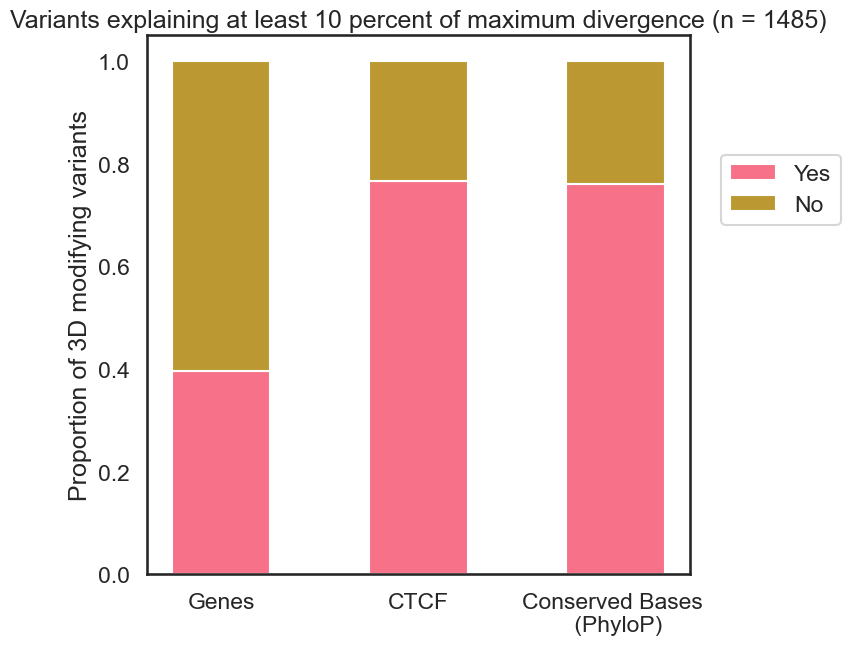

/var/folders/h7/skbyg_hd0lb0s5rwqt8vxx4r0000gn/T/ipykernel_78134/1224136074.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_vars = pd.concat([mod_vars, df])


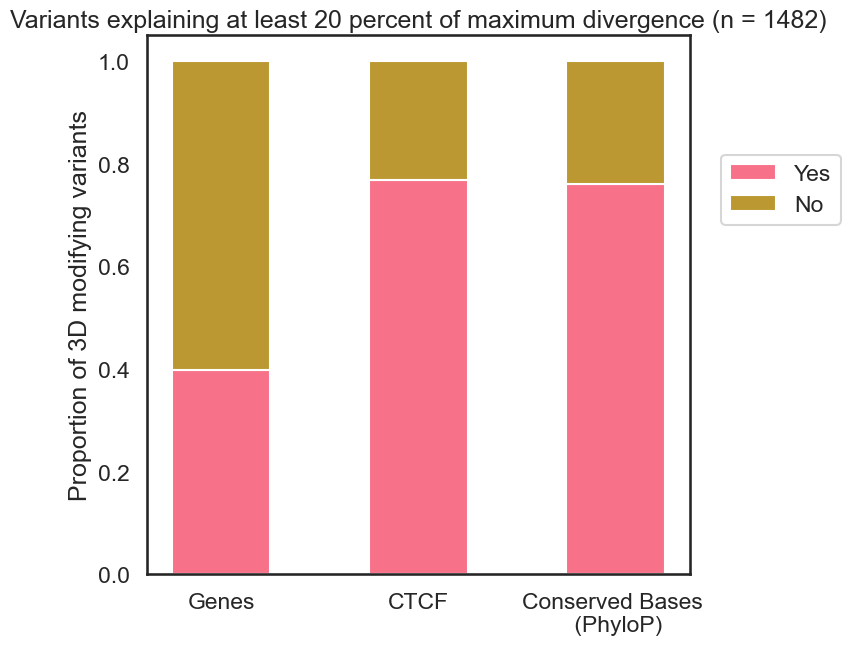

/var/folders/h7/skbyg_hd0lb0s5rwqt8vxx4r0000gn/T/ipykernel_78134/1224136074.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_vars = pd.concat([mod_vars, df])


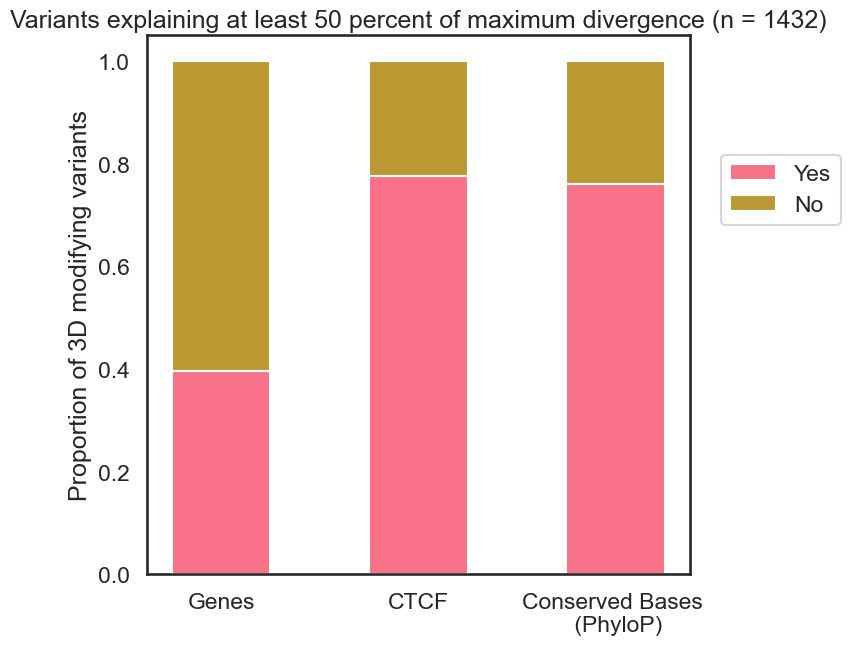

/var/folders/h7/skbyg_hd0lb0s5rwqt8vxx4r0000gn/T/ipykernel_78134/1224136074.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_vars = pd.concat([mod_vars, df])


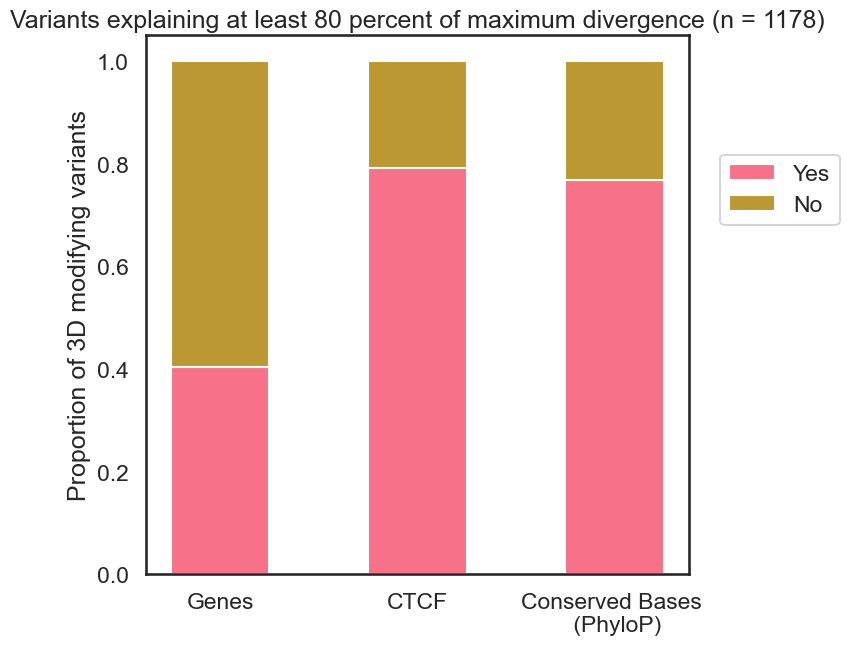

In [33]:
mod_vars_10 = get_mod_vars(0.1)
mod_vars_annot_10 = annot_vars(mod_vars_10, "10")

mod_vars_20 = get_mod_vars(0.2)
mod_vars_annot_20 = annot_vars(mod_vars_20, "20")

mod_vars_50 = get_mod_vars(0.5)
mod_vars_annot_50 = annot_vars(mod_vars_50, "50")

mod_vars_80 = get_mod_vars(0.8)
mod_vars_annot_80 = annot_vars(mod_vars_80, "80")

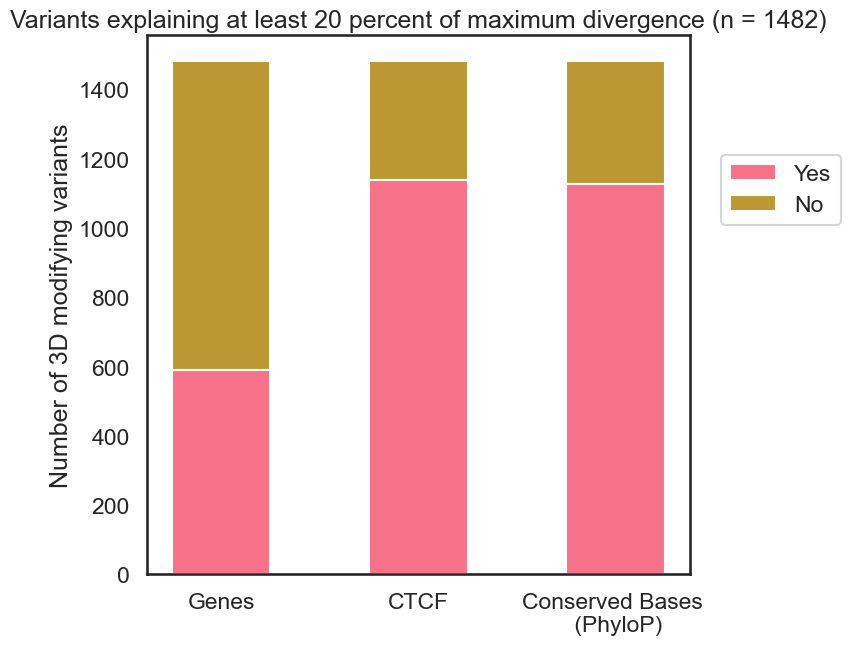

In [35]:
annots = ['Genes','CTCF', 'Conserved Bases \n (PhyloP)']
#1 = conserved phylop> 0 , 0 = fast evolving, phylop<0
annot_counts = {'Yes': [mod_vars_annot_20[mod_vars_annot_20.genes==1].shape[0], mod_vars_annot_20[mod_vars_annot_20.ctcf==1].shape[0], mod_vars_annot_20[mod_vars_annot_20.phylop>0].shape[0]], 
                'No':[ mod_vars_annot_20[mod_vars_annot_20.genes==0].shape[0], mod_vars_annot_20[mod_vars_annot_20.ctcf==0].shape[0], mod_vars_annot_20[mod_vars_annot_20.phylop<0].shape[0]]}

width = 0.5

fig, ax = plt.subplots(figsize=(7,7))
bottom = np.zeros(3)

for boolean, annot_counts in annot_counts.items():
    p = ax.bar(annots, annot_counts, width, label=boolean, bottom=bottom)
    bottom += annot_counts


plt.ylabel('Number of 3D modifying variants')
ax.legend(loc="best", bbox_to_anchor=(.8, 0., 0.5, 0.8))
plt.title("Variants explaining at least %s percent of maximum divergence (n = %s)" % (20, mod_vars_annot_20.shape[0]))
plt.savefig("%s/ism_idw_annotations.svg" % (FIG_PATH), bbox_inches = 'tight')
plt.show()

In [38]:
idw_list[idw_list.chr=='chr14']

,vcf_col_id,chr,window_start,window_end,individual,depth
"(chr14, 24117248)",1184,chr14,24117248,25165824,AFR_MSL_female_HG03082,0.025733
"(chr14, 24641536)",1184,chr14,24641536,25690112,AFR_MSL_female_HG03082,0.027853
"(chr14, 25690112)",1291,chr14,25690112,26738688,AFR_MSL_female_HG03410,0.064047
"(chr14, 26214400)",2369,chr14,26214400,27262976,EUR_TSI_female_NA20790,0.519493
"(chr14, 26738688)",2369,chr14,26738688,27787264,EUR_TSI_female_NA20790,0.403872
"(chr14, 27262976)",2262,chr14,27262976,28311552,AFR_ASW_female_NA20274,0.077683
"(chr14, 30932992)",1281,chr14,30932992,31981568,AFR_MSL_male_HG03376,0.012891
"(chr14, 31981568)",385,chr14,31981568,33030144,AMR_PUR_female_HG01162,0.030191
"(chr14, 33554432)",1315,chr14,33554432,34603008,AFR_MSL_female_HG03476,0.153561
"(chr14, 35127296)",1698,chr14,35127296,36175872,EUR_CEU_female_NA12058,0.036368
